# Introduction
This notebook implements the Circular Asymmetric Bidirectional Quantum Teleportation (CABQT) protocol, as proposed in the paper *"Asymmetrically Cyclic Quaternary User Quantum Communication Protocol"*.

The CABQT protocol is a novel quantum communication protocol that involves four participants (Alice, Bob, Charlie, and Frank) and uses a 28-qubit cluster state as the quantum channel. The goal of the protocol is to achieve quantum teleportation with enhanced security and without a centralized controller, making it suitable for distributed quantum systems.

In this notebook, we:
1. Prepare the quantum registers for each participant (Alice, Bob, Charlie, Frank).
2. Build the quantum circuit as described in the paper.
3. Simulate the protocol using Qiskit, and visualize the resulting quantum circuit.

Let's begin by installing the necessary packages to run the quantum simulations.


# Installing Required Packages
Before starting the simulation, we need to install the necessary packages:
- **qiskit[visualization]**: Provides tools for quantum computing and visualization.
- **pylatexenc**: Used for encoding and decoding LaTeX math expressions in Python.
- **qiskit-aer**: Allows us to run quantum simulations on various backends.

The following command installs all the required dependencies.


In [2]:
# Installing Needed Packages

! pip install qiskit[visualization]
! pip install pylatexenc
! pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 82.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=80771719cde61bd14c6ce180362d3dbc36125b4a13f3487b8f0e47339b2e530f
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.0 MB/s eta 0:00:00


# Defining the CABQT Protocol: Register Setup
In this section, we begin the process of setting up the quantum registers for each participant in the CABQT protocol. Each participant (Alice, Bob, Charlie, and Frank) will have:
1. **Message Registers**: These are qubits used for the teleportation messages.
   - Two-qubit message registers (`M0`, `M1`)
   - Three-qubit message registers (`M00`, `M01`, `M02`)
   
2. **Channel Registers**: These represent the quantum channel for communication, consisting of seven qubits per participant.

3. **Classical GHZ Registers**: These will be used for the classical outcomes of the GHZ measurements.

We will now define these registers for each participant and prepare them for the next steps in the protocol.


In [3]:
# CABQT — Qiskit 2.x
# -------------------------------------------------
# 1) **Register order** per person: messages first, then 7 channel qubits
#    - Messages (names you specified):
#        * Two‑qubit:  M0, M1           (e.g., Alice_M0, Alice_M1)
#        * Three‑qubit: M00, M01, M02   (e.g., Alice_M00, Alice_M01, Alice_M02)
#      → 5 message qubits per person
#    - Channel (7 per person): CH00..CH06 (zero‑padded)
# 2) Stage A: initialize **each message qubit** with arbitrary single‑qubit states (cosθ|0>+sinθ|1>)
#    then a **barrier**.
# 3) Stage B: turn messages into **Bell/GHZ** (2‑qubit: H+CX; 3‑qubit: H+CX+CX),
#    then a **barrier**.
# 4) Stage C: prepare each person’s **7‑qubit channel star**:
#       H on CH00 and CH01;  CH00→{CH02,CH03};  CH01→{CH04,CH05,CH06}
#    then a **barrier**.
# 5) Stage D: GHZ measurements + feed‑forward corrections
#    for **all eight legs** of the CABQT cycle using GHZ‑3 / GHZ‑4 rule.
#    - A(2)→B, A(3)→C
#    - B(2)→F, B(3)→A
#    - C(2)→A, C(3)→F
#    - F(2)→C, F(3)→B
# 6) At the end, it **draws** the full circuit with names.

from math import pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# ---------- Helpers to create single‑qubit registers with names ----------
def q1(name: str) -> QuantumRegister:
    return QuantumRegister(1, name)

# ---------- Build all registers in the order ----------
# People in the paper: Alice, Bob, Charlie, Frank
people = ["Alice", "Bob", "Charlie", "Frank"]

# Per‑person containers (dicts of single‑qubit regs)
M2 = {}   # two‑qubit message: keys person -> {"M0": QR, "M1": QR}
M3 = {}   # three‑qubit message: keys person -> {"M00": QR, "M01": QR, "M02": QR}
CH = {}   # channel 7‑tuple: keys person -> [QR(CH00),...,QR(CH06)]

# (Stage 5 will add classical GHZ registers later with names)
C_GHZ3 = {}
C_GHZ4 = {}

# Create named single‑qubit wires, in the order (messages then channel) for each person
all_regs = []
for P in people:
    # Messages (2‑qubit)
    M2[P] = {"M0": q1(f"{P}_M0"), "M1": q1(f"{P}_M1")}
    all_regs.extend([M2[P]["M0"], M2[P]["M1"]])
    # Messages (3‑qubit)
    M3[P] = {"M00": q1(f"{P}_M00"), "M01": q1(f"{P}_M01"), "M02": q1(f"{P}_M02")}
    all_regs.extend([M3[P]["M00"], M3[P]["M01"], M3[P]["M02"]])
    # Channel (7 qubits): CH00..CH06
    # Channel names with global numbering per the paper blocks
    # Alice: 01..07, Bob: 08..14, Charlie: 15..21, Frank: 22..28
    ch_starts = {"Alice": 1, "Bob": 8, "Charlie": 15, "Frank": 22}
    start = ch_starts[P]
    CH[P] = [q1(f"CH_{P}_{start+idx:02d}") for idx in range(7)]
    all_regs.extend(CH[P])
    # Classical GHZ outcome regs
    C_GHZ3[P] = ClassicalRegister(3, f"c_{P}_GHZ3")
    C_GHZ4[P] = ClassicalRegister(4, f"c_{P}_GHZ4")

# Build circuit with all regs
qc = QuantumCircuit(*[reg for reg in all_regs], name="CABQT_48q_paperStyle")

# Defining the Angles for State Preparation
In quantum teleportation protocols, each participant prepares their qubits in specific quantum states. These states are defined by angles that determine the superposition of |0⟩ and |1⟩ states for each qubit.

In this step, we define the **angles** used for state preparation. The angles control the rotation of each qubit, ensuring that the qubits are in the correct entangled states for the teleportation process.

The angles for each participant (Alice, Bob, Charlie, and Frank) are defined as follows:

- Each participant will have a set of angles for their respective qubits.
- The angles will be used to apply rotations to the qubits, initializing them into arbitrary single-qubit states.

Next, we will apply these angles to the qubits and prepare the quantum states accordingly.


In [4]:
# Feel free to change these angles.
angles = {
    "Alice":  [-pi/10,  pi/8,   -pi/12,  pi/9,   -pi/7 ],
    "Bob":     [ 3*pi/9, -3*pi/7,    3*pi/10, -3*pi/11,  3*pi/6 ],
    "Charlie":[-pi/11,  pi/6,   -pi/8,   pi/7,   -pi/5 ],
    "Frank":   [ 5*pi/13, -5*pi/5,    5*pi/12, -5*pi/9,   5*pi/10],
}

# Simulating the Circuit: Initialization Without Final Measurements and Corrections
At this stage, we simulate the quantum circuit to check the initialization of the qubits, without applying the final measurements and corrections. The focus here is to ensure that the qubits have been correctly initialized into the desired quantum states according to the defined angles.

1. **Initial State Measurement**:
   - We apply the defined angles to each qubit, preparing them in superposition states.
   - We measure the states to verify the correct initialization, but we avoid performing the final Bell or GHZ measurements, as well as the feed-forward corrections.
   
2. **Purpose**:
   - This step allows us to confirm that the quantum circuit has been set up correctly so far, without adding the complexity of the final measurements.

Once the circuit initialization is confirmed, we can proceed with the full simulation, which will include the final measurements and corrections.


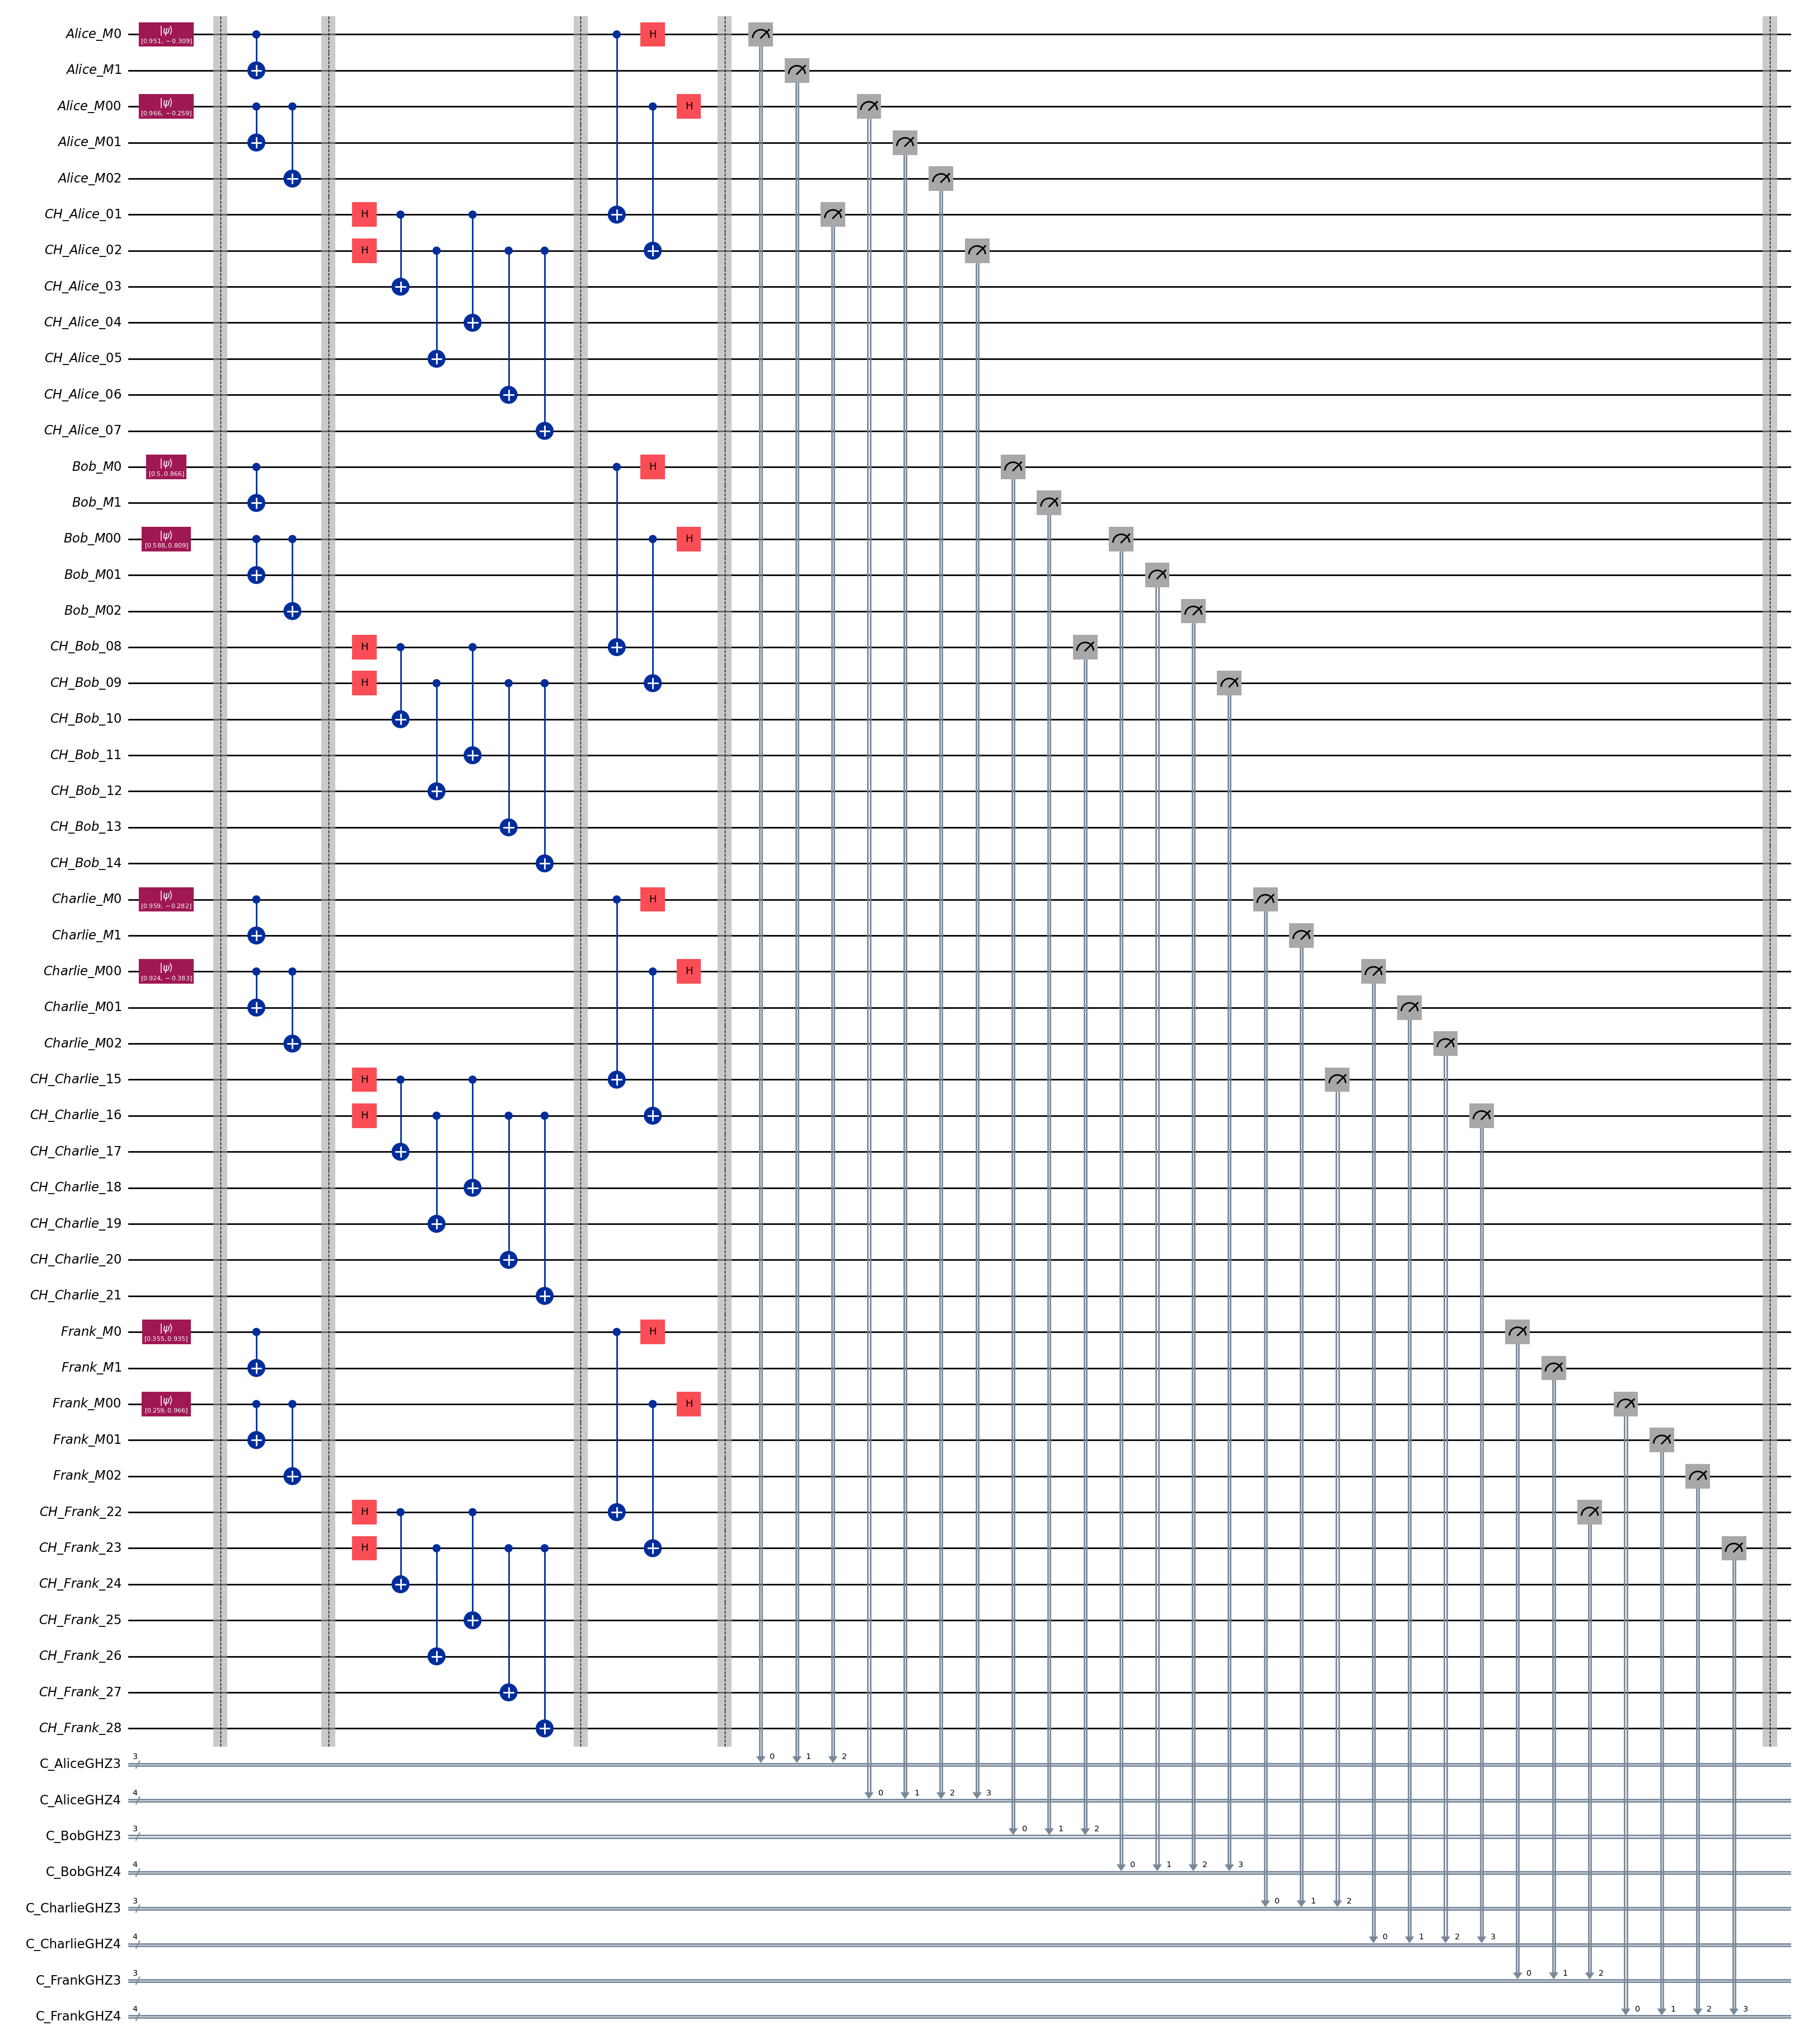

In [4]:
# ============ Stage A: arbitrary single‑qubit initializations on *every* message qubit ============
# You used cos(theta)|0> + sin(theta)|1>. Here we set a distinct theta for each message qubit.

def init_msg_qubits(P: str):
    th = angles[P]
    # Only initialize M0 (2q) and M00 (3q)
    qc.initialize([np.cos(th[0]), np.sin(th[0])], M2[P]["M0"][0])
    qc.initialize([np.cos(th[2]), np.sin(th[2])], M3[P]["M00"][0])

for P in people:
    init_msg_qubits(P)

qc.barrier()  # <<< barrier after arbitrary state prep

# ============ Stage B: entangle messages (no H, only CX as requested) ============
for P in people:
    # 2‑qubit: CX M0 -> M1
    qc.cx(M2[P]["M0"][0], M2[P]["M1"][0])
    # 3‑qubit: CX M00 -> M01 and M02
    qc.cx(M3[P]["M00"][0], M3[P]["M01"][0]); qc.cx(M3[P]["M00"][0], M3[P]["M02"][0])

qc.barrier()  # <<< barrier after message entanglement

# ============ Stage C: prepare the 7‑qubit channel star for each person ============
# Pattern per person:  H on CH00, CH01;
#   CH00 -> {CH02, CH03};   CH01 -> {CH04, CH05, CH06}
for P in people:
    ch = CH[P]
    qc.h(ch[0][0]); qc.h(ch[1][0])
    qc.cx(ch[0][0], ch[2][0]); qc.cx(ch[0][0], ch[3][0])
    qc.cx(ch[1][0], ch[4][0]); qc.cx(ch[1][0], ch[5][0]); qc.cx(ch[1][0], ch[6][0])

qc.barrier()  # <<< barrier after channel preparation

# ============ Stage D: message→channel entangling ============
# For each person P:
#  - Connecting the first qubit of the 2-qubit message (M0) to CH_{P}_01 with CX, then H on M0
#  - Connecting the first qubit of the 3-qubit message (M00) to CH_{P}_02 with CX, then H on M00
for P in people:
    # 2-qubit path: M0 → CH_{P}_01
    qc.cx(M2[P]["M0"][0], CH[P][0][0])
    qc.h(M2[P]["M0"][0])
    # 3-qubit path: M00 → CH_{P}_02
    qc.cx(M3[P]["M00"][0], CH[P][1][0])
    qc.h(M3[P]["M00"][0])

qc.barrier()  # <<< barrier after message→channel entangling

# ============ Stage 5: GHZ measurements only (no extra H/CX here) ============
# Create classical registers with names and measure:
#  - GHZ3: measure (M0, M1, CH_*_01) into C_<Person>GHZ3
#  - GHZ4: measure (M00, M01, M02, CH_*_02) into C_<Person>GHZ4
for P in people:
    c3 = ClassicalRegister(3, f"C_{P}GHZ3")
    c4 = ClassicalRegister(4, f"C_{P}GHZ4")
    qc.add_register(c3); qc.add_register(c4)
    # Measurements only (no basis-change gates here)
    qc.measure([M2[P]["M0"][0],  M2[P]["M1"][0],  CH[P][0][0]], c3)   # (M0, M1, CH_*_01)
    qc.measure([M3[P]["M00"][0], M3[P]["M01"][0], M3[P]["M02"][0], CH[P][1][0]], c4)  # (M00, M01, M02, CH_*_02)

qc.barrier()  # <<< barrier after Stage 5 GHZ measurements

# ================= Draw the completed 48‑qubit circuit =================
qc.draw('mpl', fold=120, idle_wires=False, cregbundle=True)

# Simulating the Complete Circuit: Including Final Measurements and Corrections
In this section, we simulate the full quantum circuit, incorporating all the stages of the CABQT protocol, including the final **Bell** and **GHZ measurements** along with the necessary **feed-forward corrections**.

1. **Final Measurements**:
   - We perform the required **GHZ state measurements** for each participant to verify entanglement and facilitate the teleportation process.
   
2. **Corrections**:
   - Based on the measurement outcomes, feed-forward corrections are applied to the qubits to ensure the correct final state.
   
3. **Circuit Simulation**:
   - The complete circuit, including all the quantum operations (gates, measurements, corrections), is now simulated using the quantum simulator backend.
   
4. **Visualization**:
   - The resulting quantum circuit is visualized to show how the quantum operations and measurements are carried out in the CABQT protocol.

At the end of this step, we will analyze the results of the simulation to validate the correctness of the protocol and its quantum operations.


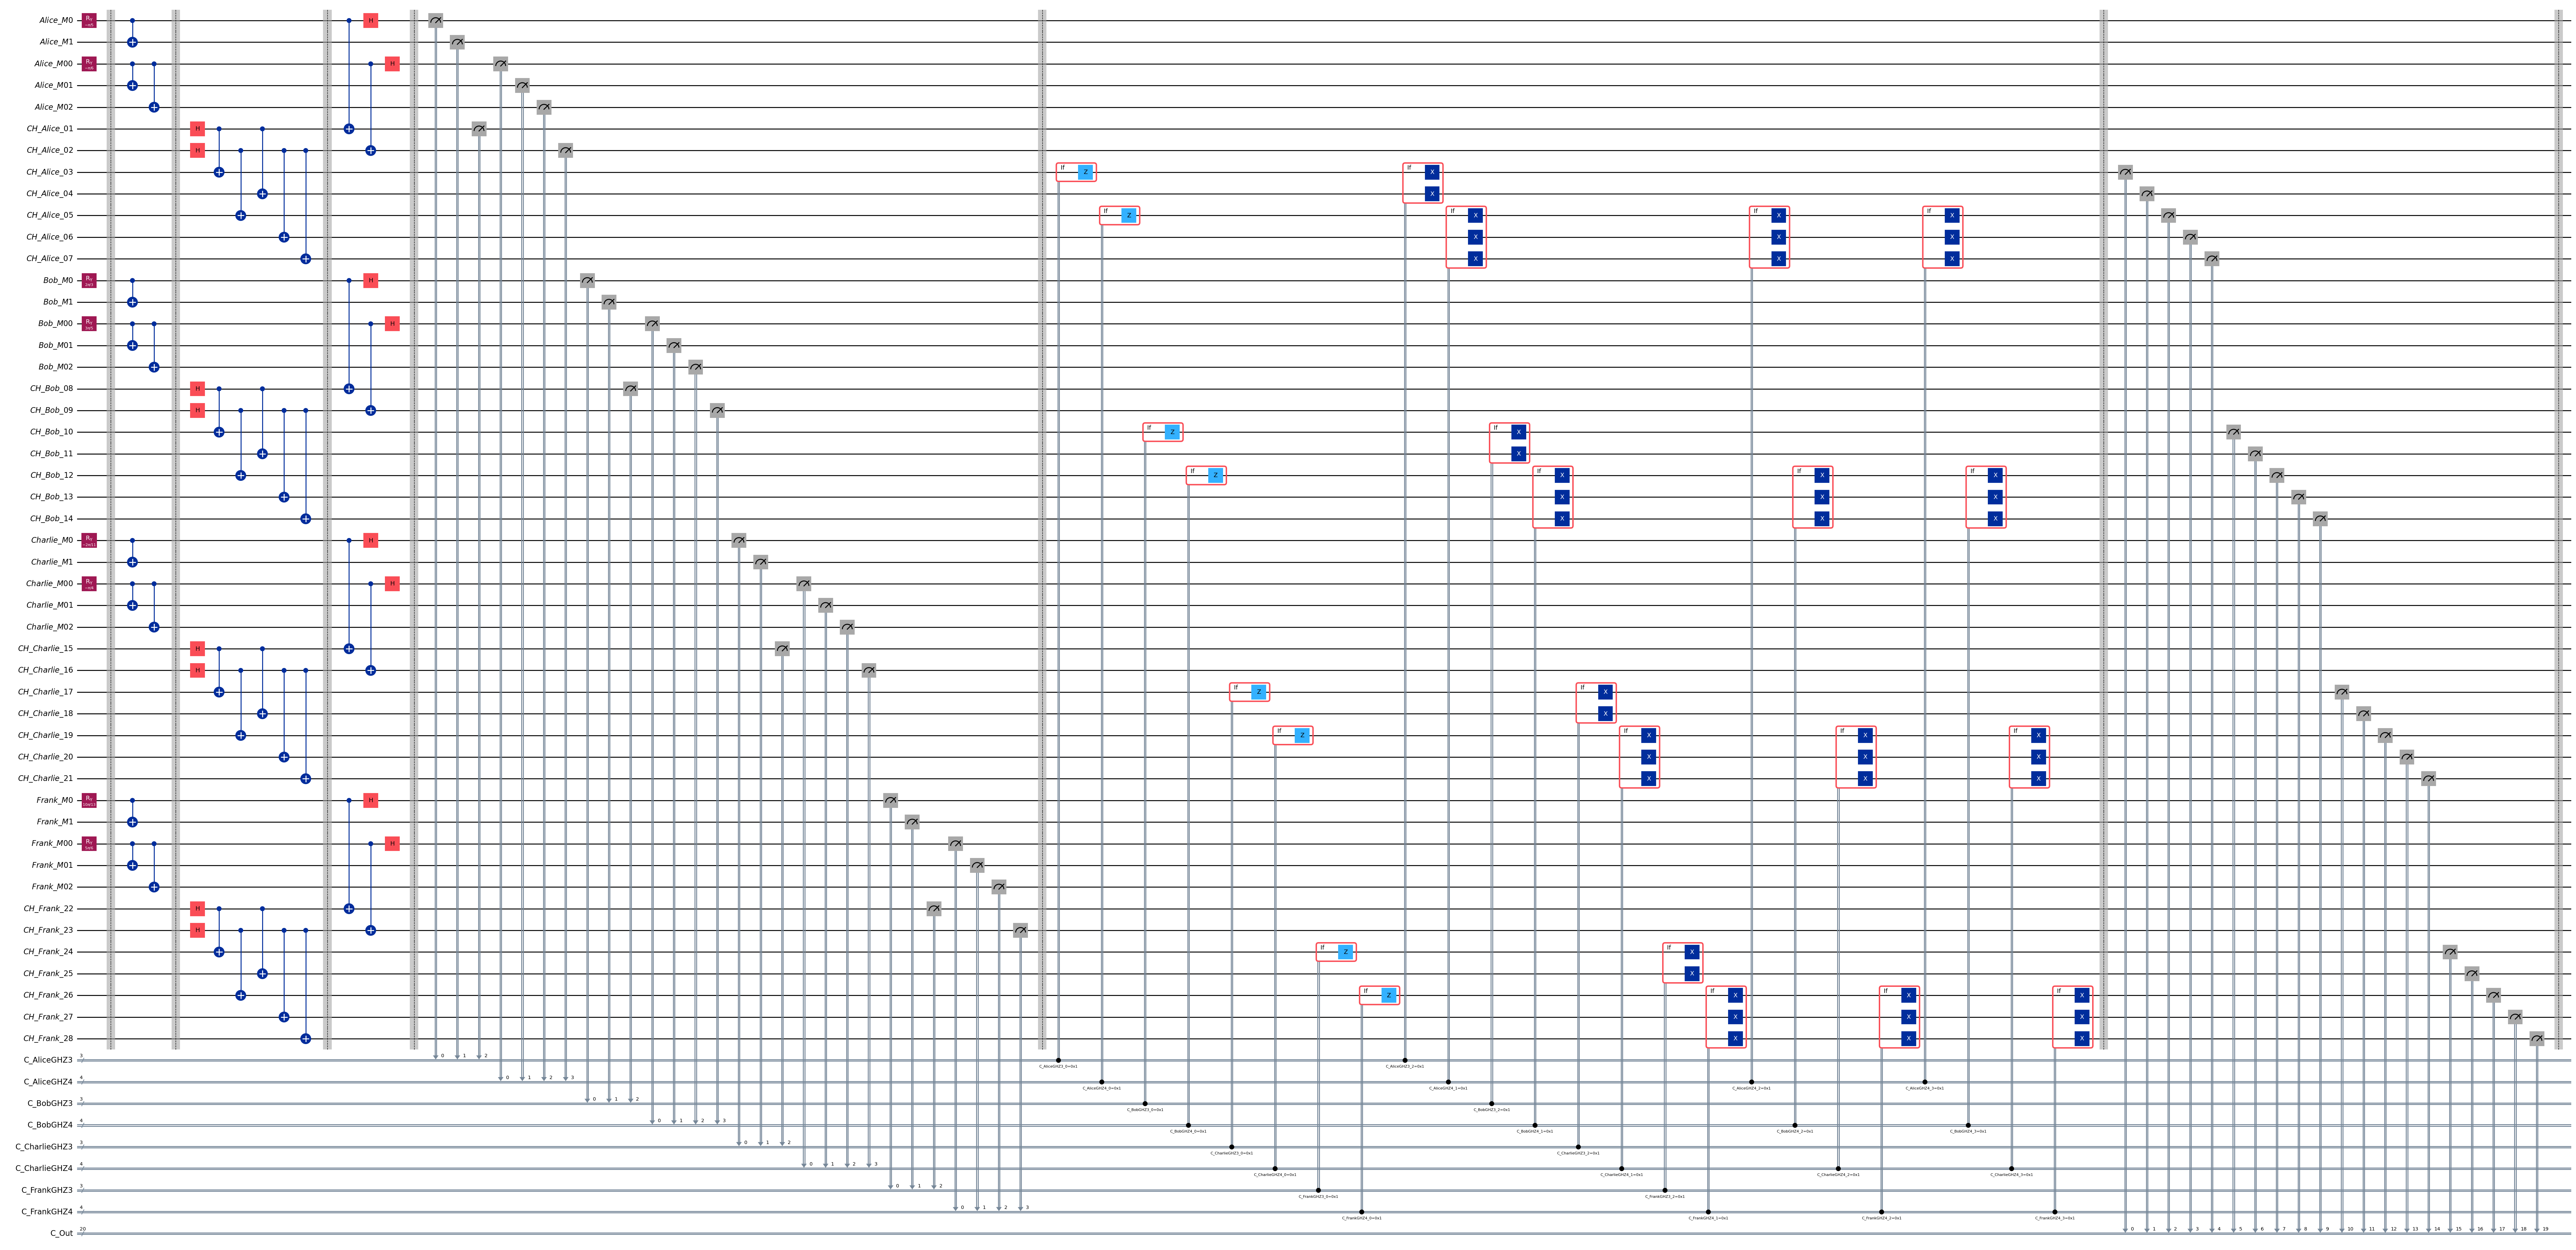

In [5]:
# CABQT — 48‑qubit Complete Circuit
# ----------------------------------------------------------------------------

from math import pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# ---------- helpers ----------
def q1(name: str) -> QuantumRegister:
    return QuantumRegister(1, name)

people = ["Alice", "Bob", "Charlie", "Frank"]

# containers
M2, M3, CH = {}, {}, {}
C_GHZ3, C_GHZ4 = {}, {}

# build regs (messages first, then channels)
all_regs = []
ch_starts = {"Alice": 1, "Bob": 8, "Charlie": 15, "Frank": 22}

for P in people:
    # 2q message
    M2[P] = {"M0": q1(f"{P}_M0"), "M1": q1(f"{P}_M1")}
    all_regs.extend([M2[P]["M0"], M2[P]["M1"]])
    # 3q message
    M3[P] = {"M00": q1(f"{P}_M00"), "M01": q1(f"{P}_M01"), "M02": q1(f"{P}_M02")}
    all_regs.extend([M3[P]["M00"], M3[P]["M01"], M3[P]["M02"]])
    # channel 7 with global numbering
    start = ch_starts[P]
    CH[P] = [q1(f"CH_{P}_{start+idx:02d}") for idx in range(7)]  # 01..07, 08..14, ...
    all_regs.extend(CH[P])

qc = QuantumCircuit(*all_regs, name="CABQT_48q_Final_StageLabels")

# ---------- Stage 1: initialization , only M0 & M00 ----------

for P in people:
    th = angles[P]
    qc.ry(2*th[0], M2[P]["M0"][0])   # cosθ|0> + sinθ|1>
    qc.ry(2*th[2], M3[P]["M00"][0])
qc.barrier()

# ---------- Stage 2: message entangle (CX only) ----------
for P in people:
    qc.cx(M2[P]["M0"][0],  M2[P]["M1"][0])          # 2q GHZ on message
    qc.cx(M3[P]["M00"][0], M3[P]["M01"][0])         # 3q GHZ on message
    qc.cx(M3[P]["M00"][0], M3[P]["M02"][0])
qc.barrier()

# ---------- Stage 3: channel preperation ----------
# roots are CH_*_01 and CH_*_02; fanout to leaves
for P in people:
    ch = CH[P]
    # root1 → leaves 03,04
    qc.h(ch[0][0])
    qc.cx(ch[0][0], ch[2][0])
    qc.cx(ch[0][0], ch[3][0])
    # root2 → leaves 05,06,07
    qc.h(ch[1][0])
    qc.cx(ch[1][0], ch[4][0])
    qc.cx(ch[1][0], ch[5][0])
    qc.cx(ch[1][0], ch[6][0])
qc.barrier()

# ---------- Stage 4: Sending Messages to Channel ----------

for P in people:
    # 2q hook
    qc.cx(M2[P]["M0"][0],  CH[P][0][0])
    qc.h(M2[P]["M0"][0])

    # 3q hook
    qc.cx(M3[P]["M00"][0], CH[P][1][0])
    qc.h(M3[P]["M00"][0])
qc.barrier()

# ---------- Stage 5: GHZ measurements (measurement-only) ----------
for P in people:
    c3 = ClassicalRegister(3, f"C_{P}GHZ3")
    c4 = ClassicalRegister(4, f"C_{P}GHZ4")
    qc.add_register(c3); qc.add_register(c4)
    C_GHZ3[P], C_GHZ4[P] = c3, c4

    # GHZ-3: (M0, M1, CH_*_01)
    qc.measure([M2[P]["M0"][0], M2[P]["M1"][0], CH[P][0][0]], c3)

    # GHZ-4: (M00, M01, M02, CH_*_02)
    qc.measure([M3[P]["M00"][0], M3[P]["M01"][0], M3[P]["M02"][0], CH[P][1][0]], c4)
qc.barrier()

# ---------- Stage 6: feed-forward corrections on Reciever leaves ----------

for P in people:
    # 2q targets (leaves under root1)
    t2_1 = CH[P][2][0]   # *_03
    t2_2 = CH[P][3][0]   # *_04
    b0, b1, b2 = C_GHZ3[P][0], C_GHZ3[P][1], C_GHZ3[P][2]
    with qc.if_test((b0, 1)):
        qc.z(t2_1)
    '''with qc.if_test((b1, 1)):
        qc.x(t2_1); qc.x(t2_2)'''
    with qc.if_test((b2, 1)):
        qc.x(t2_1); qc.x(t2_2)

    # 3q targets (leaves under root2)
    t3_1 = CH[P][4][0]   # *_05
    t3_2 = CH[P][5][0]   # *_06
    t3_3 = CH[P][6][0]   # *_07
    c0, c1, c2, c3 = C_GHZ4[P][0], C_GHZ4[P][1], C_GHZ4[P][2], C_GHZ4[P][3]
    with qc.if_test((c0, 1)):
        qc.z(t3_1)
    with qc.if_test((c1, 1)):
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
    with qc.if_test((c2, 1)):
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
    with qc.if_test((c3, 1)):
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
qc.barrier()

# ---------- Stage 7: final readout into single C_Out (20 bits) ----------
C_Out = ClassicalRegister(20, "C_Out")
qc.add_register(C_Out)
for idx, P in enumerate(people):
    base = idx * 5
    qc.measure([CH[P][2][0], CH[P][3][0], CH[P][4][0], CH[P][5][0], CH[P][6][0]],
               [C_Out[base+0], C_Out[base+1], C_Out[base+2], C_Out[base+3], C_Out[base+4]])
qc.barrier()

# ---------- draw (hi-dpi save optional) ----------
qc.draw('mpl', fold=120, idle_wires=False, cregbundle=True)
# fig.savefig('CABQT_48q_Final_Labeled3.png', dpi=100, bbox_inches='tight')

In [5]:
# @title
# ---------- helpers ----------
def q1(name: str) -> QuantumRegister:
    return QuantumRegister(1, name)

people = ["Alice", "Bob", "Charlie", "Frank"]

# containers
M2, M3, CH = {}, {}, {}
C_GHZ3, C_GHZ4 = {}, {}

# build regs (messages first, then channels)
all_regs = []
ch_starts = {"Alice": 1, "Bob": 8, "Charlie": 15, "Frank": 22}

for P in people:
    # 2q message
    M2[P] = {"M0": q1(f"{P}_M0"), "M1": q1(f"{P}_M1")}
    all_regs.extend([M2[P]["M0"], M2[P]["M1"]])
    # 3q message
    M3[P] = {"M00": q1(f"{P}_M00"), "M01": q1(f"{P}_M01"), "M02": q1(f"{P}_M02")}
    all_regs.extend([M3[P]["M00"], M3[P]["M01"], M3[P]["M02"]])
    # channel 7 with global numbering
    start = ch_starts[P]
    CH[P] = [q1(f"CH_{P}_{start+idx:02d}") for idx in range(7)]  # 01..07, 08..14, ...
    all_regs.extend(CH[P])

qc = QuantumCircuit(*all_regs, name="CABQT_48q_Final_StageLabels")

# ---------- Stage 1: init only leaders M0 & M00 ----------

for P in people:
    th = angles[P]
    qc.ry(2*th[0], M2[P]["M0"][0])   # cosθ|0> + sinθ|1>
    qc.ry(2*th[2], M3[P]["M00"][0])
qc.barrier()

# ---------- Stage 2: message entangle (CX only) ----------
for P in people:
    qc.cx(M2[P]["M0"][0],  M2[P]["M1"][0])          # 2q GHZ on message
    qc.cx(M3[P]["M00"][0], M3[P]["M01"][0])         # 3q GHZ on message
    qc.cx(M3[P]["M00"][0], M3[P]["M02"][0])
qc.barrier()

# ---------- Stage 3: channel star (after hook) ----------
# roots are CH_*_01 and CH_*_02; fanout to leaves
for P in people:
    ch = CH[P]
    # root1 → leaves 03,04
    qc.h(ch[0][0])
    qc.cx(ch[0][0], ch[2][0])
    qc.cx(ch[0][0], ch[3][0])
    # root2 → leaves 05,06,07
    qc.h(ch[1][0])
    qc.cx(ch[1][0], ch[4][0])
    qc.cx(ch[1][0], ch[5][0])
    qc.cx(ch[1][0], ch[6][0])
qc.barrier()

# ---------- Stage 4: HOOK (before star) ----------
#   2q: CX(M0 -> CH_*_01);  H(M0) **commented out**
#   3q: CX(M00 -> CH_*_02); H(M00) **included**
for P in people:
    # 2q hook
    qc.cx(M2[P]["M0"][0],  CH[P][0][0])     # root #1 = *_01
    # qc.h(M2[P]["M0"][0])                  # <-- commented by request

    # 3q hook
    qc.cx(M3[P]["M00"][0], CH[P][1][0])     # root #2 = *_02
    #qc.h(M3[P]["M00"][0])                   # <-- included by request
qc.barrier()

# ---------- Stage 5: GHZ measurements (measurement-only) ----------
for P in people:
    c3 = ClassicalRegister(3, f"C_{P}GHZ3")
    c4 = ClassicalRegister(4, f"C_{P}GHZ4")
    qc.add_register(c3); qc.add_register(c4)
    C_GHZ3[P], C_GHZ4[P] = c3, c4

    # GHZ-3: (M0, M1, CH_*_01)
    qc.measure([M2[P]["M0"][0], M2[P]["M1"][0], CH[P][0][0]], c3)

    # GHZ-4: (M00, M01, M02, CH_*_02)
    qc.measure([M3[P]["M00"][0], M3[P]["M01"][0], M3[P]["M02"][0], CH[P][1][0]], c4)
qc.barrier()

# ---------- Stage 6 ----------
for P in people:
    # 2q targets (leaves under root1)
    t2_1 = CH[P][2][0]   # *_03
    t2_2 = CH[P][3][0]   # *_04
    b0, b1, b2 = C_GHZ3[P][0], C_GHZ3[P][1], C_GHZ3[P][2]
    with qc.if_test((b0, 1)):
        qc.z(t2_1)
    '''with qc.if_test((b1, 1)):
        qc.x(t2_1); qc.x(t2_2)'''
    with qc.if_test((b2, 1)):
        qc.x(t2_1); qc.x(t2_2)

    # 3q targets (leaves under root2)
    t3_1 = CH[P][4][0]   # *_05
    t3_2 = CH[P][5][0]   # *_06
    t3_3 = CH[P][6][0]   # *_07
    c0, c1, c2, c3 = C_GHZ4[P][0], C_GHZ4[P][1], C_GHZ4[P][2], C_GHZ4[P][3]
    with qc.if_test((c0, 1)):
        qc.z(t3_1)
    with qc.if_test((c1, 1)):  # <- re-enable if needed
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
    with qc.if_test((c2, 1)):
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
    with qc.if_test((c3, 1)):
        qc.x(t3_1); qc.x(t3_2); qc.x(t3_3)
qc.barrier()

# ---------- Stage 7: final readout into single C_Out (20 bits) ----------
C_Out = ClassicalRegister(20, "C_Out")
qc.add_register(C_Out)
for idx, P in enumerate(people):
    base = idx * 5
    qc.measure([CH[P][2][0], CH[P][3][0], CH[P][4][0], CH[P][5][0], CH[P][6][0]],
               [C_Out[base+0], C_Out[base+1], C_Out[base+2], C_Out[base+3], C_Out[base+4]])

# Running the Simulation
In this section, we will run the simulation of the quantum circuit using Qiskit's **AerSimulator**. The simulation will utilize the **Matrix Product State (MPS)** method, which is one of the several available methods for simulating quantum circuits in Qiskit.

1. **Simulator Setup**:
   - We configure the simulator with the method `matrix_product_state`. Other available methods include `tensor_network` and `extended_stabilizer`.
   
2. **Transpiling**:
   - The quantum circuit is transpiled to optimize it for the selected simulator.

3. **Simulation Execution**:
   - The quantum circuit is run with 4096 shots to obtain the measurement results.
   
4. **Counting Results**:
   - The results are collected and the measurement counts are extracted for further analysis.

The following code runs the simulation and stores the results, which will be used to analyze the success of the protocol.


In [6]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

sim = AerSimulator(method="matrix_product_state")   # or: method="tensor_network" / "extended_stabilizer"
tqc = transpile(qc, sim, optimization_level=0)
res = sim.run(tqc, shots=4096).result()
counts = res.get_counts()

# Visualizing the Results: Initial State Measurements
In this step, we visualize the results of the simulation by plotting the initial states of the quantum registers. We will use **Qiskit's plot_histogram** function to create a bar chart that represents the measurement outcomes for the quantum states.

**Bar Chart**:
   - The histogram will display the counts of each possible measurement outcome across all qubits.
   
**Analysis**:
   - By analyzing the histogram, we can verify that the initial states have been set correctly, showing the distribution of measurement results for each participant's qubits.

This visualization helps us confirm that the quantum states were initialized properly before proceeding with further steps like the final corrections and teleportation operations.


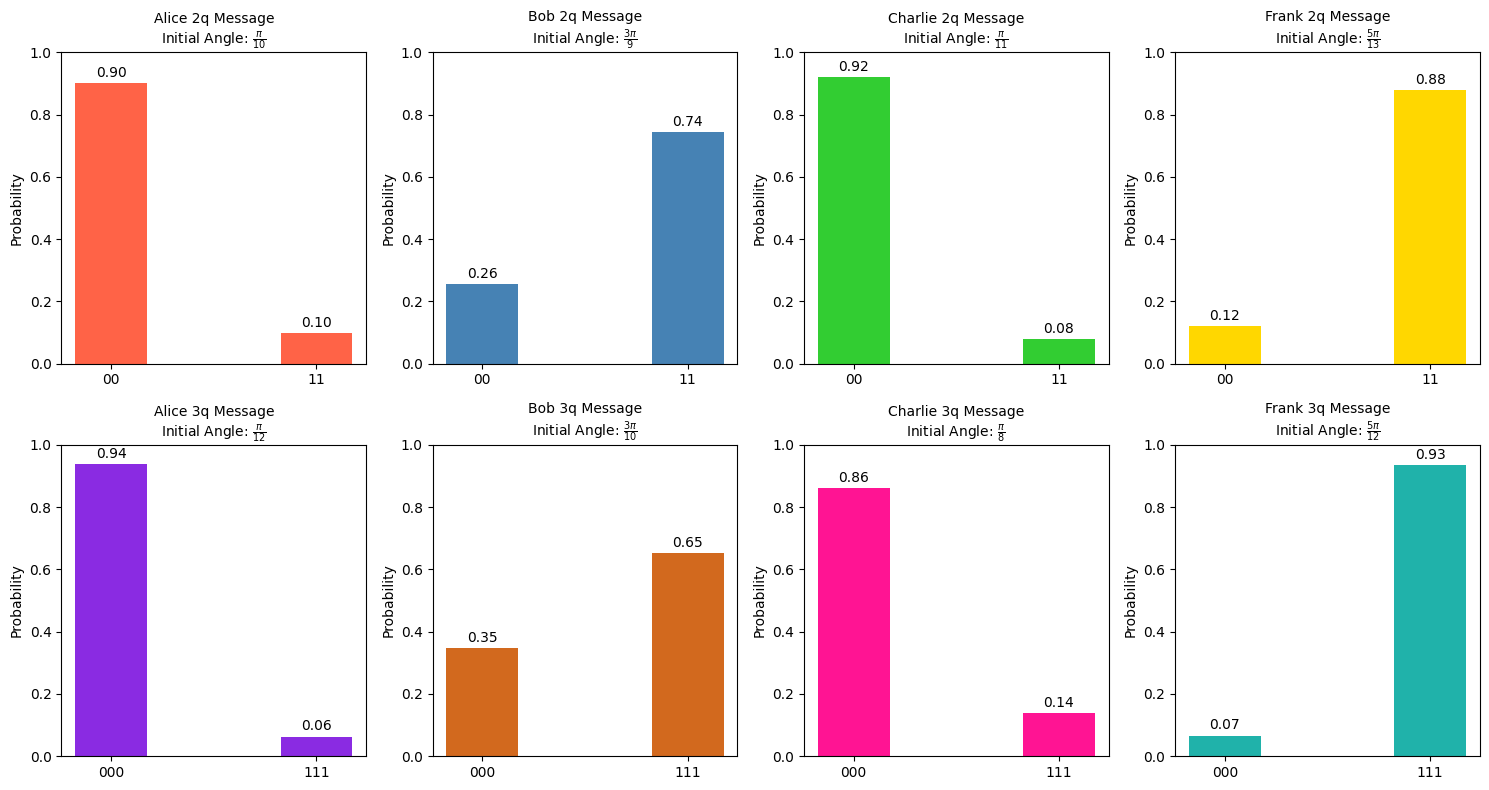

In [8]:
# --- locate classical registers by name ---
creg_c3  = next(cr for cr in qc.cregs if cr.name == "C_AliceGHZ3")
creg_c4  = next(cr for cr in qc.cregs if cr.name == "C_AliceGHZ4")
creg_out = next(cr for cr in qc.cregs if cr.name == "C_Out")

# --- create a list of participants ---
people = ["Alice", "Bob", "Charlie", "Frank"]

# --- indices for each participant's 2q and 3q message ---
indices_2q = {}
indices_3q = {}
for P in people:
    # 2q message (M0,M1) for each person
    creg_2q = next(cr for cr in qc.cregs if cr.name == f"C_{P}GHZ3")
    idx_2q = [
        qc.find_bit(creg_2q[0]).index,  # M0
        qc.find_bit(creg_2q[1]).index   # M1
    ]
    indices_2q[P] = idx_2q

    # 3q message (M00,M01,M02) for each person
    creg_3q = next(cr for cr in qc.cregs if cr.name == f"C_{P}GHZ4")
    idx_3q = [
        qc.find_bit(creg_3q[0]).index,  # M00
        qc.find_bit(creg_3q[1]).index,  # M01
        qc.find_bit(creg_3q[2]).index   # M02
    ]
    indices_3q[P] = idx_3q

# --- define colors for each subplot ---
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', '#D2691E', '#FF1493', '#20B2AA']

# --- define angles in LaTeX format ---
#
angles = {
    "Alice":  [r"$\frac{\pi}{10}$", r"$\frac{\pi}{12}$"],
    "Bob":     [r"$\frac{3{\pi}}{9}$", r"$\frac{3{\pi}}{10}$"],
    "Charlie": [r"$\frac{\pi}{11}$", r"$\frac{\pi}{8}$"],
    "Frank":   [r"$\frac{5{\pi}}{13}$", r"$\frac{5{\pi}}{12}$"]
}

# --- plotting setup ---
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns

# --- plot 2q and 3q messages for each person ---
bar_width = 0.35  # Decrease the width of each bar

for idx, P in enumerate(people):
    # 2-qubit message
    m_msg2 = marginal_counts(counts, indices=indices_2q[P])
    # Sort the keys of the 2-qubit messages to ensure '00' comes before '11'
    sorted_keys_2q = sorted(m_msg2.keys())  # Ensure 00 comes before 11
    probabilities_2q = {key: val / sum(m_msg2.values()) for key, val in m_msg2.items()}  # Convert to probabilities
    axes[0, idx].bar(sorted_keys_2q, [probabilities_2q[k] for k in sorted_keys_2q], color=colors[idx], width=bar_width)
    axes[0, idx].set_title(f'{P} 2q Message\nInitial Angle: {angles[P][0]}', fontsize=10)
    axes[0, idx].set_ylabel('Probability')
    axes[0, idx].set_ylim(0, 1)  # Set y-axis from 0 to 1

    # Display probability values on top of the bars (with increased font size)
    for x, val in zip(sorted_keys_2q, [probabilities_2q[k] for k in sorted_keys_2q]):
        axes[0, idx].text(x, val + 0.02, f'{val:.2f}', ha='center', fontsize=10)

    # 3-qubit message
    m_msg3 = marginal_counts(counts, indices=indices_3q[P])
    probabilities_3q = {key: val / sum(m_msg3.values()) for key, val in m_msg3.items()}  # Convert to probabilities

    # Sort keys to show states in the correct order (000 -> 111)
    sorted_keys_3q = sorted(probabilities_3q.keys())

    axes[1, idx].bar(sorted_keys_3q, [probabilities_3q[k] for k in sorted_keys_3q], color=colors[(idx+4) % len(colors)], width=bar_width)  # Change color for variety
    axes[1, idx].set_title(f'{P} 3q Message\nInitial Angle: {angles[P][1]}', fontsize=10)
    axes[1, idx].set_ylabel('Probability')
    axes[1, idx].set_ylim(0, 1)  # Set y-axis from 0 to 1

    # Display probability values on top of the bars (with increased font size)
    for x, val in zip(sorted_keys_3q, [probabilities_3q[k] for k in sorted_keys_3q]):
        axes[1, idx].text(x, val + 0.02, f'{val:.2f}', ha='center', fontsize=10)

# --- adjust layout ---
plt.tight_layout()
plt.show()

# Simulating and Visualizing the 2-Qubit State of Alice
In this section, we focus on the simulation of the 2-qubit state. Initially, each participant prepares their qubits in a superposition of states defined by specific angles. The initial state of the quantum system is measured, and the results are visualized using a bar chart.

After the initial state is set and the measurement is done, the state is teleported through the quantum channel. We then measure the final teleported state, again visualizing it using a histogram to observe any changes.

By comparing the initial and final states, we can verify if the teleportation protocol was successful and if the final state matches the original state, as expected in quantum teleportation protocols.


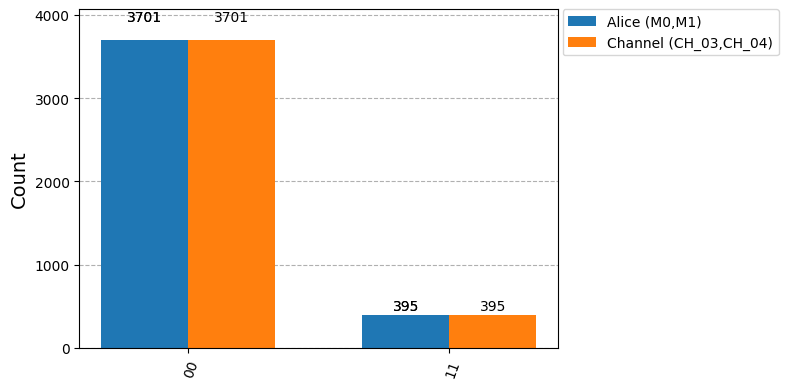

In [9]:

creg_c3  = next(cr for cr in qc.cregs if cr.name == "C_AliceGHZ3")
creg_out = next(cr for cr in qc.cregs if cr.name == "C_Out")

idx_msg = [qc.find_bit(creg_c3[0]).index, qc.find_bit(creg_c3[1]).index]

idx_out = [qc.find_bit(creg_out[0]).index, qc.find_bit(creg_out[1]).index]

m_msg  = marginal_counts(counts, indices=idx_msg)
m_out  = marginal_counts(counts, indices=idx_out)

plot_histogram([m_msg, m_out], legend=['Alice (M0,M1)', 'Channel (CH_03,CH_04)'], figsize=(8,4))


# Simulating and Visualizing the 3-Qubit State of Alice
In this part, we extend the simulation to the 3-qubit state. Similar to the 2-qubit case, we begin by preparing the quantum states with the appropriate angles for each qubit. After initializing the states, we measure the initial state of the quantum system and visualize the results with a histogram.

Once the initial state is prepared, the teleportation process is carried out. The final teleported state is measured and compared to the initial state. A bar chart will show the measurement outcomes for both the initial and teleported states.

This comparison helps us ensure that the teleportation process is working correctly, and that the final state has been successfully transferred to the recipient while preserving the quantum properties of the initial state.


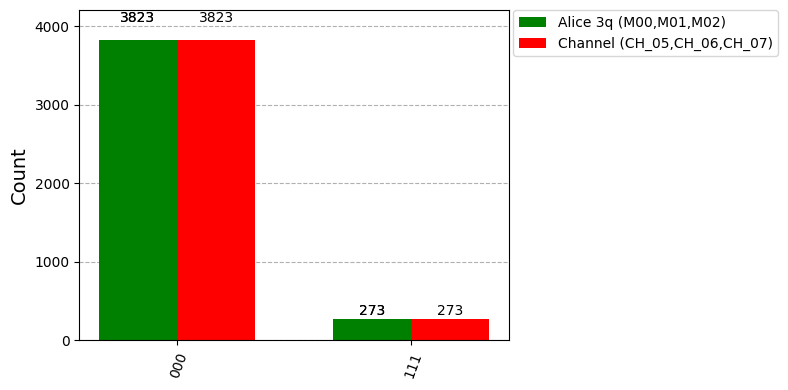

In [10]:

# --- simulate the full 48q circuit 'qc' with a memory-friendly method ---
sim = AerSimulator(method="matrix_product_state")   # or: "tensor_network", "extended_stabilizer"
tqc = transpile(qc, sim, optimization_level=0)
res = sim.run(tqc, shots=4096).result()
counts = res.get_counts()

# --- locate classical registers by name ---
creg_c4  = next(cr for cr in qc.cregs if cr.name == "C_AliceGHZ4")  # (M00, M01, M02, CH_Alice_02)
creg_out = next(cr for cr in qc.cregs if cr.name == "C_Out")        # [A:03,04,05,06,07 | B:... | C:... | F:...]

# --- indices for Alice's 3q message (M00,M01,M02) = first 3 bits of C_AliceGHZ4 ---
idx_msg3 = [
    qc.find_bit(creg_c4[0]).index,
    qc.find_bit(creg_c4[1]).index,
    qc.find_bit(creg_c4[2]).index,
]

# --- indices for Alice's 3q leaves (CH_Alice_05,06,07) = C_Out bits 2,3,4 in our build ---
idx_out3 = [
    qc.find_bit(creg_out[2]).index,  # CH_Alice_05
    qc.find_bit(creg_out[3]).index,  # CH_Alice_06
    qc.find_bit(creg_out[4]).index,  # CH_Alice_07
]

# --- build marginals & plot ---
m_msg3 = marginal_counts(counts, indices=idx_msg3)
m_out3 = marginal_counts(counts, indices=idx_out3)

plot_histogram(
    [m_msg3, m_out3],
    legend=['Alice 3q (M00,M01,M02)', 'Channel (CH_05,CH_06,CH_07)'],
    color=['green', 'red'],
    figsize=(8,4)
)


# Simulating Alice’s Part: Shortened Version of the Circuit
To make the simulation more manageable, especially when dealing with a large 48-qubit circuit, we focus on Alice’s part of the protocol. Alice will act as the sender, and she will be connected to either Bob or Charlie to send her qubits through the quantum channel.

In this simplified version:
- Alice's part of the circuit is isolated and simulated with just a **2-qubit state**.
- The goal is to simulate Alice preparing the quantum state, sending it to Bob or Charlie, and measuring the result after teleportation.
- By focusing on Alice’s qubits and the channel connection with a single receiver, we reduce the complexity of the simulation, making it easier to handle noise simulations and verify correctness before scaling up to the full 48-qubit setup.

This approach helps us:
1. Debug and verify the basic steps of quantum teleportation involving Alice.
2. Simulate and analyze how noise affects the quantum state during transmission.
3. Gradually extend the process to the entire circuit once Alice's part is confirmed to work as expected.


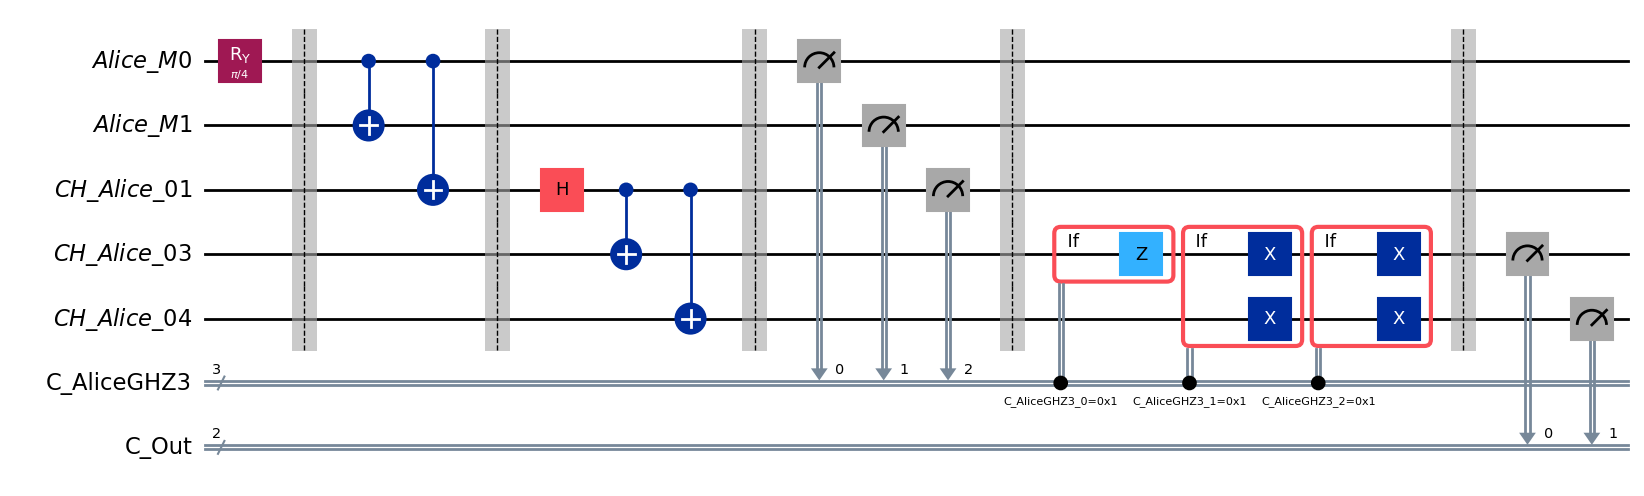

In [11]:
# --- Build baseline input circuit (Alice-only 2q) ---

# Named wires
Alice_M0 = QuantumRegister(1, "Alice_M0")
Alice_M1 = QuantumRegister(1, "Alice_M1")
CH01 = QuantumRegister(1, "CH_Alice_01")
CH03 = QuantumRegister(1, "CH_Alice_03")
CH04 = QuantumRegister(1, "CH_Alice_04")

C_in  = ClassicalRegister(2, "C_in")     # (M0,M1)
C_g3  = ClassicalRegister(3, "C_AliceGHZ3")
C_out = ClassicalRegister(2, "C_Out")    # (CH03,CH04)

# 1) Baseline: just prep + entangle, then measure M0,M1 in Z
qc_in = QuantumCircuit(Alice_M0, Alice_M1, name="Alice_in")
theta = pi/8
qc_in.ry(2*theta, Alice_M0[0])
qc_in.cx(Alice_M0[0], Alice_M1[0])
qc_in.add_register(C_in)
qc_in.measure([Alice_M0[0], Alice_M1[0]], C_in)

# 2) Teleport leg with GHZ-3 mapping + corrections
qc = QuantumCircuit(Alice_M0, Alice_M1, CH01, CH03, CH04, C_g3, C_out, name="Alice_2q_tele")

# Stage 1: init
qc.ry(2*theta, Alice_M0[0]); qc.barrier()
# Stage 2: message entangle
qc.cx(Alice_M0[0], Alice_M1[0]);

qc.cx(Alice_M0[0], CH01[0])

qc.barrier()
# Stage 3: star
qc.h(CH01[0]); qc.cx(CH01[0], CH03[0]); qc.cx(CH01[0], CH04[0]); qc.barrier()
# Stage 4: hook to channel (include H for GHZ-3 mapping)
''' qc.cx(Alice_M0[0], CH01[0]); qc.h(Alice_M0[0]); qc.barrier() '''
# Stage 5: GHZ-3 measurement (M0,M1,CH01) → C_AliceGHZ3
qc.measure([Alice_M0[0], Alice_M1[0], CH01[0]], C_g3); qc.barrier()
# Stage 6: corrections on leaves — use b0,b1,b2 = C_AliceGHZ3[0:3]

b0, b1, b2 = C_g3[0], C_g3[1], C_g3[2]
with qc.if_test((b0, 1)): qc.z(CH03[0])                 # Z on first leaf if b0
with qc.if_test((b1, 1)): qc.x(CH03[0]); qc.x(CH04[0])  # X on both if b1
with qc.if_test((b2, 1)): qc.x(CH03[0]); qc.x(CH04[0])  # X on both if b2
qc.barrier()
# Stage 7: measure leaves → C_Out
qc.measure([CH03[0], CH04[0]], C_out)

# --- simulate both and compare Z-basis distributions ---
sim = AerSimulator()
res_in   = sim.run(transpile(qc_in,  sim, optimization_level=0), shots=4096).result()
res_tele = sim.run(transpile(qc,     sim, optimization_level=0), shots=4096).result()

cnt_in   = res_in.get_counts()
cnt_out  = res_tele.get_counts()

# qc_in has just C_in; qc has C_Out among other bits — marginalize to the two we care about
from qiskit.result.utils import marginal_counts
m_in  = cnt_in  # already 2 bits
# in qc, find the positions of C_Out bits and marginalize
idx_out = [qc.find_bit(C_out[0]).index, qc.find_bit(C_out[1]).index]
m_out = marginal_counts(cnt_out, indices=idx_out)

# plot_histogram([m_in, m_out], legend=['Input Z(M0,M1)', 'Output Z(CH03,CH04)'], figsize=(7,3.5))
qc.draw('mpl')

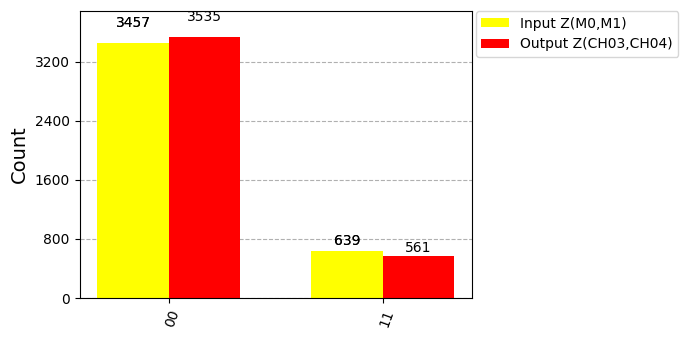

In [12]:
plot_histogram([m_in, m_out], legend=['Input Z(M0,M1)', 'Output Z(CH03,CH04)'], color=['yellow', 'red'] ,figsize=(7,3.5))

# Simulating Alice’s Part: 3-Qubit State (Shortened Version)
In this part, we extend the simulation to Alice's 3-qubit state. As with the 2-qubit state, we isolate Alice’s qubits and simulate the quantum teleportation process with a shorter version of the circuit.

The focus here is:
- Alice prepares a **3-qubit state** and sends it to either Bob or Charlie via the quantum channel.
- This shortened simulation allows us to work with just Alice's qubits and a single receiver, simplifying the process and making it more manageable for testing and noise simulations.

By isolating Alice’s 3-qubit state, we can focus on the core quantum operations and observe how the state behaves during the teleportation process. This helps in debugging and optimizing the protocol before scaling it up to the full 48-qubit circuit.


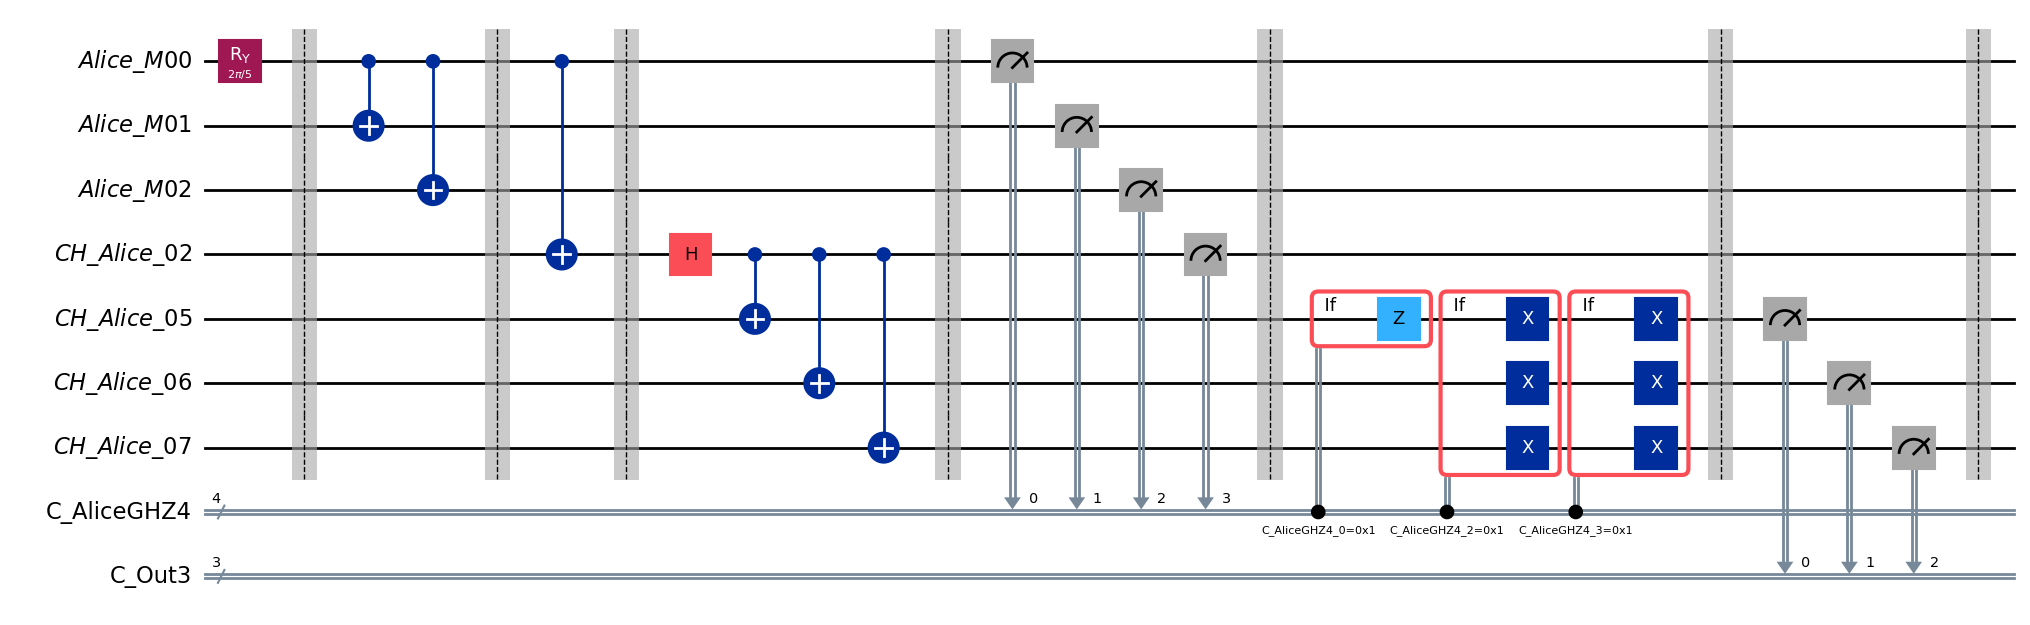

In [13]:
# Alice-only, 3-qubit leg (short version)

# --- named wires ---
Alice_M00 = QuantumRegister(1, "Alice_M00")
Alice_M01 = QuantumRegister(1, "Alice_M01")
Alice_M02 = QuantumRegister(1, "Alice_M02")

CH02 = QuantumRegister(1, "CH_Alice_02")   # root for 3q leg
CH05 = QuantumRegister(1, "CH_Alice_05")   # leaves
CH06 = QuantumRegister(1, "CH_Alice_06")
CH07 = QuantumRegister(1, "CH_Alice_07")

C_in3  = ClassicalRegister(3, "C_in3")         # baseline (M00,M01,M02)
C_g4   = ClassicalRegister(4, "C_AliceGHZ4")   # (M00,M01,M02,CH02) in this order
C_out3 = ClassicalRegister(3, "C_Out3")        # (CH05,CH06,CH07)

theta = pi/5

# ---------- Baseline input: just prep + GHZ on message, then measure M00,M01,M02 ----------
qc_in = QuantumCircuit(Alice_M00, Alice_M01, Alice_M02, name="Alice_in3")
qc_in.ry(2*theta, Alice_M00[0])                 # init only M00
qc_in.cx(Alice_M00[0], Alice_M01[0])            # GHZ entangle
qc_in.cx(Alice_M00[0], Alice_M02[0])
qc_in.add_register(C_in3)
qc_in.measure([Alice_M00[0], Alice_M01[0], Alice_M02[0]], C_in3)

# ---------- Teleport leg (GHZ-4) ----------
qc = QuantumCircuit(Alice_M00, Alice_M01, Alice_M02, CH02, CH05, CH06, CH07,
                    C_g4, C_out3, name="Alice_3q_tele")

# Stage 1: init
qc.ry(2*theta, Alice_M00[0]); qc.barrier()

# Stage 2: message entangle (GHZ on message only)
qc.cx(Alice_M00[0], Alice_M01[0])
qc.cx(Alice_M00[0], Alice_M02[0])
qc.barrier()

# Stage 4: message→channel root, then H on message qubit for GHZ-4 mapping
#qc.h(Alice_M00[0])
qc.cx(Alice_M00[0], CH02[0])
qc.barrier()

# Stage 3: channel star on CH02 → {CH05, CH06, CH07}
qc.h(CH02[0])
qc.cx(CH02[0], CH05[0])
qc.cx(CH02[0], CH06[0])
qc.cx(CH02[0], CH07[0])
qc.barrier()

# Stage 5: GHZ-4 measurement ONLY : measure (M00,M01,M02,CH02)
qc.measure([Alice_M00[0], Alice_M01[0], Alice_M02[0], CH02[0]], C_g4)
qc.barrier()


# Stage 6: corrections on leaves using c0..c3 = [M00, M01, M02, CH02]
c0, c1, c2, c3 = C_g4[0], C_g4[1], C_g4[2], C_g4[3]

# if c0==1: Z on first leaf (CH05)
with qc.if_test((c0, 1)):
    qc.z(CH05[0])

'''
# if c1==1: X on all three leaves
with qc.if_test((c1, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])
'''

# if c2==1: X on all three leaves
with qc.if_test((c2, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])

# if c3==1: X on all three leaves
with qc.if_test((c3, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])

qc.barrier()


# Stage 7: final readout of leaves
qc.measure([CH05[0], CH06[0], CH07[0]], C_out3)
qc.barrier()

# --- simulate & compare histograms ---
sim = AerSimulator()
res_in   = sim.run(transpile(qc_in, sim, optimization_level=0), shots=4096).result()
res_tele = sim.run(transpile(qc,    sim, optimization_level=0), shots=4096).result()

cnt_in   = res_in.get_counts()      # already just C_in3
cnt_out  = res_tele.get_counts()

# marginalize qc's results to C_Out3 bits
idx_out = [qc.find_bit(C_out3[0]).index, qc.find_bit(C_out3[1]).index, qc.find_bit(C_out3[2]).index]
m_out   = marginal_counts(cnt_out, indices=idx_out)

# plot_histogram([cnt_in, m_out], legend=['Input Z(M00,M01,M02)', 'Output Z(CH05,CH06,CH07)'], figsize=(8,3.5))

# Optional: view circuit
qc.draw('mpl', fold=90, idle_wires=False, cregbundle=True)


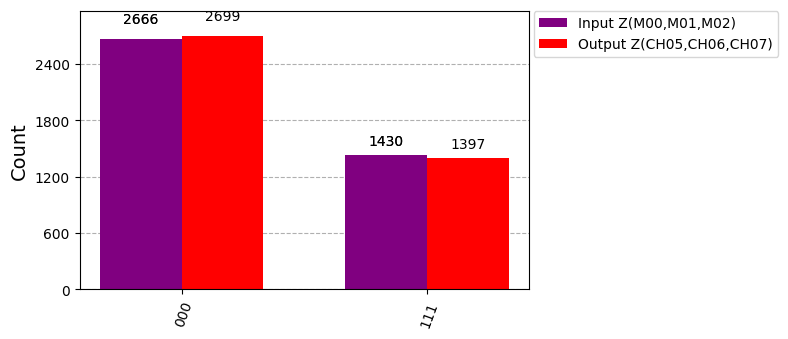

In [14]:
plot_histogram([cnt_in, m_out], legend=['Input Z(M00,M01,M02)', 'Output Z(CH05,CH06,CH07)'], color=['purple', 'red'] ,figsize=(8,3.5))

# Introduction to Noise in Quantum Simulations: Focus on Depolarizing Noise
In quantum computing, noise is an inherent challenge that can disrupt the delicate quantum states used for teleportation and other protocols. Unlike classical computing, where noise can be easily mitigated, quantum systems are highly susceptible to errors caused by various types of noise.

One of the most disruptive types of noise in quantum teleportation is **depolarizing noise**. Depolarizing noise occurs when a quantum system undergoes random transformations, leading to the loss of information. In the context of teleportation, this noise can cause the quantum state to become mixed and lose its entanglement, severely affecting the fidelity of the teleported state.

Depolarizing noise affects the qubits by randomly replacing them with a completely mixed state. This means that instead of being in a specific quantum state, the qubits can randomly become any state with equal probability. This randomness can destroy the entanglement required for successful quantum teleportation, making it a critical factor to consider when simulating realistic quantum communication systems.

In the following section, we will apply depolarizing noise to the quantum circuit to simulate its effects and observe how the teleportation protocol performs under noise. This allows us to analyze the robustness of the protocol and its potential for practical implementation in noisy quantum environments.


# Simulating 2-Qubit State with Depolarizing Noise
In this section, we apply **depolarizing noise** to the 2-qubit state simulation. The goal is to observe how noise affects the teleportation protocol, particularly how it distorts the initial quantum state.

### Effect of Depolarizing Noise on the 2-Qubit State:
When depolarizing noise is introduced, the qubits no longer remain in the pure entangled state. The state is gradually mixed, and other states begin to appear in the measurement outcomes. This happens because the depolarizing noise reduces the coherence of the quantum state, which is essential for teleportation.

As the noise level increases (i.e., higher depolarizing probability \( p \)), the entanglement between Alice’s qubits and the receiver (Bob or Charlie) is degraded. The fidelity of the teleportation decreases, and measurement results show a mix of outcomes instead of the expected state.

In this simulation, we will:
- Apply depolarizing noise to the 2-qubit state.
- Observe the resulting histogram and how the noise introduces unwanted states into the measurement outcomes.
- Compare the noisy results to the ideal teleportation outcomes, highlighting the destructive impact of noise on the teleportation process.

This will demonstrate the challenges faced in real quantum systems and help assess the protocol’s robustness to noise.


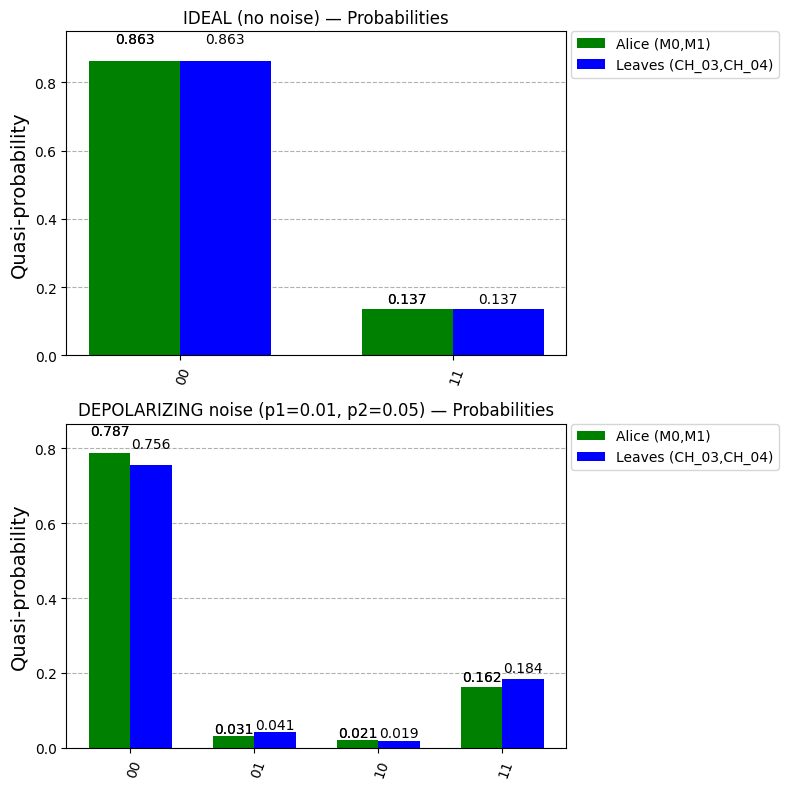

In [15]:
# Alice-only, 2-qubit leg (short version) — Qiskit 2.x + Depolarizing Noise

from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
from qiskit.result.utils import marginal_counts
import matplotlib.pyplot as plt

# --- named wires ---
Alice_M0 = QuantumRegister(1, "Alice_M0")
Alice_M1 = QuantumRegister(1, "Alice_M1")
CH_Alice_01 = QuantumRegister(1, "CH_Alice_01")
CH_Alice_03 = QuantumRegister(1, "CH_Alice_03")
CH_Alice_04 = QuantumRegister(1, "CH_Alice_04")

C_AliceGHZ3 = ClassicalRegister(3, "C_AliceGHZ3")
C_Out       = ClassicalRegister(2, "C_Out")

qc = QuantumCircuit(
    Alice_M0, Alice_M1,
    CH_Alice_01, CH_Alice_03, CH_Alice_04,
    C_AliceGHZ3, C_Out,
    name="Alice_2q_short"
)

# 1) init (only M0)
theta = pi/8
qc.ry(2*theta, Alice_M0[0])
qc.barrier()

# 2) message entangle
qc.cx(Alice_M0[0], Alice_M1[0])
qc.barrier()

# 3) channel prep
qc.h(CH_Alice_01[0])
qc.cx(CH_Alice_01[0], CH_Alice_03[0])
qc.cx(CH_Alice_01[0], CH_Alice_04[0])
qc.barrier()

# 4) message → channel
qc.cx(Alice_M0[0], CH_Alice_01[0])
qc.barrier()

# 5) GHZ-3 measurement
qc.measure([Alice_M0[0], Alice_M1[0], CH_Alice_01[0]], C_AliceGHZ3)
qc.barrier()

# 6) corrections
b0, b1, b2 = C_AliceGHZ3[0], C_AliceGHZ3[1], C_AliceGHZ3[2]
with qc.if_test((b0, 1)):
    qc.z(CH_Alice_03[0])
with qc.if_test((b2, 1)):
    qc.x(CH_Alice_03[0]); qc.x(CH_Alice_04[0])
qc.barrier()

# 7) final readout
qc.measure([CH_Alice_03[0], CH_Alice_04[0]], C_Out)
qc.barrier()

# ---------------------------
# Noise model: depolarizing
# ---------------------------
p1 = 0.01
p2 = 0.05
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['sx','x','rz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

# ---------------------------
# Simulate (ideal vs noisy)
# ---------------------------
shots = 4096
seed = 1234

sim_ideal = AerSimulator(seed_simulator=seed)
sim_noisy  = AerSimulator(noise_model=noise_model, seed_simulator=seed)

tqc_ideal = transpile(qc, sim_ideal, optimization_level=0)
tqc_noisy = transpile(qc, sim_noisy,  optimization_level=0)

res_ideal = sim_ideal.run(tqc_ideal, shots=shots).result()
res_noisy = sim_noisy.run(tqc_noisy,   shots=shots).result()

counts_ideal = res_ideal.get_counts()
counts_noisy = res_noisy.get_counts()

# ---------------------------
# Convert counts → probabilities
# ---------------------------
def counts_to_probs(counts):
    total = sum(counts.values())
    return {k: v/total for k,v in counts.items()}

counts_ideal_prob = counts_to_probs(counts_ideal)
counts_noisy_prob = counts_to_probs(counts_noisy)

# ---------------------------
# Marginals (message vs leaves) using probabilities
# ---------------------------
idx_msg = [qc.find_bit(C_AliceGHZ3[0]).index, qc.find_bit(C_AliceGHZ3[1]).index]
idx_out = [qc.find_bit(C_Out[0]).index,       qc.find_bit(C_Out[1]).index]

m_msg_ideal  = marginal_counts(counts_ideal_prob, indices=idx_msg)
m_out_ideal  = marginal_counts(counts_ideal_prob, indices=idx_out)
m_msg_noisy  = marginal_counts(counts_noisy_prob, indices=idx_msg)
m_out_noisy  = marginal_counts(counts_noisy_prob, indices=idx_out)

# ---------------------------
# Plot: Probabilities on Y-axis
# ---------------------------
plt.figure(figsize=(8, 8))

# Ideal
ax1 = plt.subplot(2, 1, 1)
plot_histogram([m_msg_ideal, m_out_ideal],
               legend=['Alice (M0,M1)', 'Leaves (CH_03,CH_04)'],color=['green','blue'],
               figsize=(8,3.2), ax=ax1)
ax1.set_title('IDEAL (no noise) — Probabilities')

# Noisy
ax2 = plt.subplot(2, 1, 2)
plot_histogram([m_msg_noisy, m_out_noisy],
               legend=['Alice (M0,M1)', 'Leaves (CH_03,CH_04)'], color=['green','blue'],
               figsize=(8,3.2), ax=ax2)
ax2.set_title(f'DEPOLARIZING noise (p1={p1}, p2={p2}) — Probabilities')

plt.tight_layout()
plt.show()


# Simulating 3-Qubit State with Depolarizing Noise
In this part of the simulation, we extend the analysis to the 3-qubit state. Just like the 2-qubit case, we apply **depolarizing noise** to the 3-qubit state and observe its impact on the teleportation process.

### Effect of Depolarizing Noise on the 3-Qubit State:
The introduction of depolarizing noise to a 3-qubit state has a similar effect as in the 2-qubit case but with more noticeable consequences due to the increased complexity of the state. As the noise increases, the entanglement between Alice’s qubits and the receiver (Bob or Charlie) is further degraded. This causes the qubits to lose their coherence, leading to a mixture of states.

Instead of the expected teleportation outcome, the measurement results show a range of states that are no longer representative of the initial entangled state. As we increase the depolarizing probability \( p \), more states appear in the results, and the teleportation process becomes less reliable.

In this simulation:
- We observe how depolarizing noise distorts the 3-qubit state.
- The results show the appearance of other states in the measurement outcomes, indicating the loss of coherence.
- The impact of depolarizing noise on the fidelity of teleportation is clearly visible, and we compare the noisy results with the ideal outcomes.

This demonstrates the sensitivity of quantum teleportation protocols to noise and the importance of minimizing its effects for reliable quantum communication.


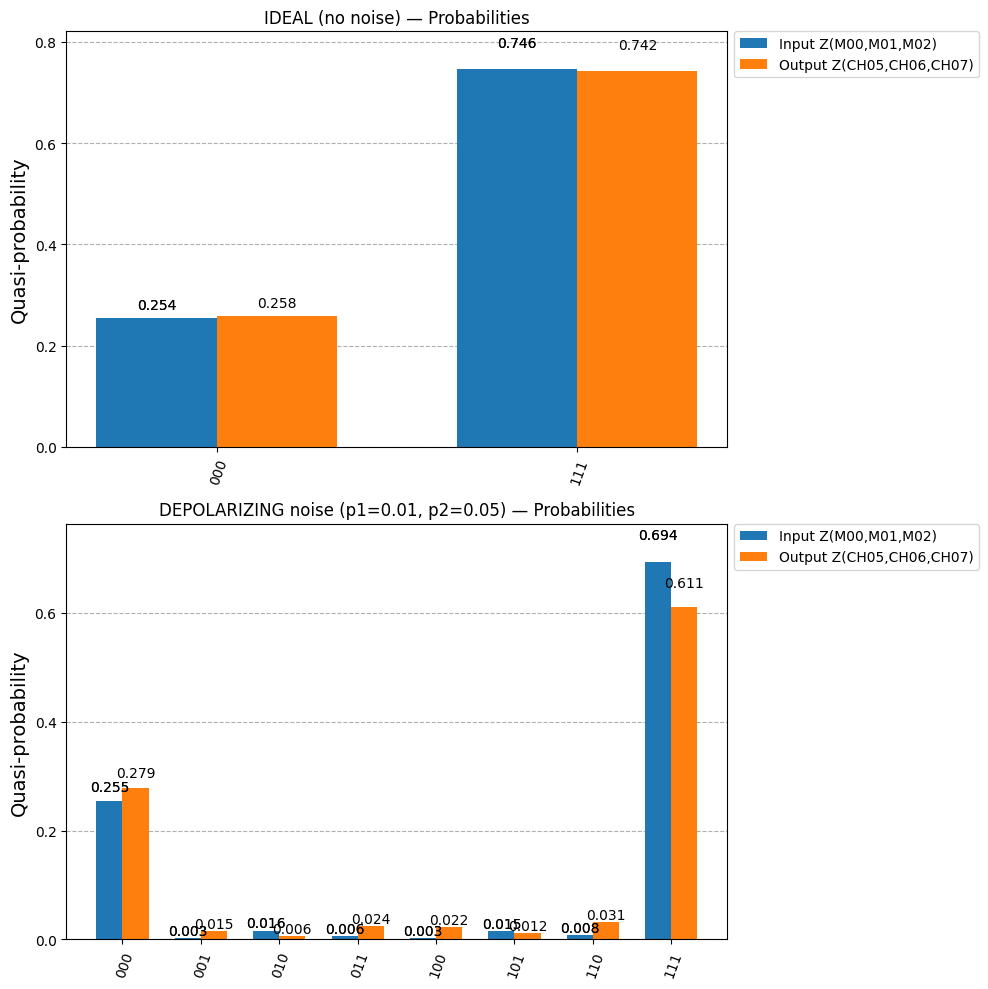

In [16]:
# Alice-only, 3-qubit leg (short version)
# + Depolarizing noise — PROBABILITIES on plots

from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
from qiskit.result.utils import marginal_counts
import matplotlib.pyplot as plt

# --- named wires ---
Alice_M00 = QuantumRegister(1, "Alice_M00")
Alice_M01 = QuantumRegister(1, "Alice_M01")
Alice_M02 = QuantumRegister(1, "Alice_M02")

CH02 = QuantumRegister(1, "CH_Alice_02")   # root for 3q leg
CH05 = QuantumRegister(1, "CH_Alice_05")   # leaves
CH06 = QuantumRegister(1, "CH_Alice_06")
CH07 = QuantumRegister(1, "CH_Alice_07")

C_in3  = ClassicalRegister(3, "C_in3")         # baseline (M00,M01,M02)
C_g4   = ClassicalRegister(4, "C_AliceGHZ4")   # (M00,M01,M02,CH02)
C_out3 = ClassicalRegister(3, "C_Out3")        # (CH05,CH06,CH07)

theta = pi/3

# ---------- Baseline input: prep + GHZ on message, measure M00,M01,M02 ----------
qc_in = QuantumCircuit(Alice_M00, Alice_M01, Alice_M02, name="Alice_in3")
qc_in.ry(2*theta, Alice_M00[0])                 # init only M00
qc_in.cx(Alice_M00[0], Alice_M01[0])            # GHZ entangle
qc_in.cx(Alice_M00[0], Alice_M02[0])
qc_in.add_register(C_in3)
qc_in.measure([Alice_M00[0], Alice_M01[0], Alice_M02[0]], C_in3)

# ---------- Teleport leg (GHZ-4) ----------
qc = QuantumCircuit(Alice_M00, Alice_M01, Alice_M02, CH02, CH05, CH06, CH07,
                    C_g4, C_out3, name="Alice_3q_tele")

# Stage 1: init
qc.ry(2*theta, Alice_M00[0]); qc.barrier()

# Stage 2: message entangle (GHZ on message only)
qc.cx(Alice_M00[0], Alice_M01[0])
qc.cx(Alice_M00[0], Alice_M02[0])
qc.barrier()

# Stage 3: channel star on CH02 → {CH05, CH06, CH07}
qc.h(CH02[0])
qc.cx(CH02[0], CH05[0])
qc.cx(CH02[0], CH06[0])
qc.cx(CH02[0], CH07[0])
qc.barrier()

# Stage 4: message→channel root, then H on message qubit for GHZ-4 mapping
qc.cx(Alice_M00[0], CH02[0])
qc.h(Alice_M00[0])
qc.barrier()

# Stage 5: GHZ-4 measurement ONLY (no extra ops)
qc.measure([Alice_M00[0], Alice_M01[0], Alice_M02[0], CH02[0]], C_g4)
qc.barrier()

# Stage 6: corrections using c0..c3 = [M00, M01, M02, CH02]
c0, c1, c2, c3 = C_g4[0], C_g4[1], C_g4[2], C_g4[3]

with qc.if_test((c0, 1)):  # if c0==1: Z on first leaf (CH05)
    qc.z(CH05[0])

# if any of c1,c2,c3 == 1: X on all three leaves (each implemented separately)
with qc.if_test((c1, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])
with qc.if_test((c2, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])
with qc.if_test((c3, 1)):
    qc.x(CH05[0]); qc.x(CH06[0]); qc.x(CH07[0])

qc.barrier()

# Stage 7: final readout of leaves
qc.measure([CH05[0], CH06[0], CH07[0]], C_out3)
qc.barrier()

# ---------------------------
# Noise model: Depolarizing
# ---------------------------
p1 = 0.01   # single-qubit depolarizing probability
p2 = 0.05   # two-qubit depolarizing probability

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['sx', 'x', 'rz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

# ---------------------------
# Simulate (IDEAL vs NOISY)
# ---------------------------
shots = 4096
seed = 1234

sim_ideal = AerSimulator(seed_simulator=seed)
sim_noisy  = AerSimulator(noise_model=noise_model, seed_simulator=seed)

# Transpile per backend
tqc_in_ideal   = transpile(qc_in, sim_ideal, optimization_level=0)
tqc_tele_ideal = transpile(qc,    sim_ideal, optimization_level=0)

tqc_in_noisy   = transpile(qc_in, sim_noisy,  optimization_level=0)
tqc_tele_noisy = transpile(qc,    sim_noisy,  optimization_level=0)

# Run
res_in_ideal    = sim_ideal.run(tqc_in_ideal,   shots=shots).result()
res_tele_ideal  = sim_ideal.run(tqc_tele_ideal, shots=shots).result()
res_in_noisy    = sim_noisy.run(tqc_in_noisy,   shots=shots).result()
res_tele_noisy  = sim_noisy.run(tqc_tele_noisy, shots=shots).result()

# Collect counts
cnt_in_ideal   = res_in_ideal.get_counts()          # already only C_in3
cnt_out_ideal  = res_tele_ideal.get_counts()
cnt_in_noisy   = res_in_noisy.get_counts()
cnt_out_noisy  = res_tele_noisy.get_counts()

# ---------------------------
# Convert counts → probabilities
# ---------------------------
def counts_to_probs(counts):
    total = sum(counts.values())
    return {k: v/total for k, v in counts.items()} if total else {}

cnt_in_ideal_p   = counts_to_probs(cnt_in_ideal)
cnt_out_ideal_p  = counts_to_probs(cnt_out_ideal)
cnt_in_noisy_p   = counts_to_probs(cnt_in_noisy)
cnt_out_noisy_p  = counts_to_probs(cnt_out_noisy)

# Marginalize teleport results to C_Out3 bits (on probability dicts)
idx_out = [
    qc.find_bit(C_out3[0]).index,
    qc.find_bit(C_out3[1]).index,
    qc.find_bit(C_out3[2]).index
]
m_out_ideal_p = marginal_counts(cnt_out_ideal_p, indices=idx_out)
m_out_noisy_p = marginal_counts(cnt_out_noisy_p, indices=idx_out)

# ---------------------------
# Plot: PROBABILITIES (top=ideal, bottom=noisy)
# ---------------------------
plt.figure(figsize=(10, 10))

# IDEAL
ax1 = plt.subplot(2, 1, 1)
plot_histogram([cnt_in_ideal_p, m_out_ideal_p],
               legend=['Input Z(M00,M01,M02)', 'Output Z(CH05,CH06,CH07)'],
               figsize=(9,3.6), ax=ax1)
ax1.set_title('IDEAL (no noise) — Probabilities')

# NOISY
ax2 = plt.subplot(2, 1, 2)
plot_histogram([cnt_in_noisy_p, m_out_noisy_p],
               legend=['Input Z(M00,M01,M02)', 'Output Z(CH05,CH06,CH07)'],
               figsize=(9,3.6), ax=ax2)
ax2.set_title(f'DEPOLARIZING noise (p1={p1}, p2={p2}) — Probabilities')

plt.tight_layout()
plt.show()

# Optional: print probability dictionaries
#print("IDEAL  input probs:", dict(cnt_in_ideal_p))
#print("IDEAL output probs:", dict(m_out_ideal_p))
#print("NOISY  input probs:", dict(cnt_in_noisy_p))
#print("NOISY output probs:", dict(m_out_noisy_p))

# Analyzing Fidelity: Impact of Noise on Teleportation
In this section, we analyze how the **fidelity** of the quantum teleportation process changes when depolarizing noise is introduced. Fidelity measures how close the teleported state is to the original state, and it is a key indicator of the success of the teleportation protocol.

### Fidelity in the Presence of Noise:
As we add depolarizing noise, we expect the fidelity of teleportation to decrease. The noise disrupts the quantum states, leading to errors in the teleported state. The more noise is applied, the greater the degradation in fidelity.

In this simulation, we will observe how the fidelity changes as we increase the noise level. Specifically:
- For the 2-qubit and 3-qubit states, we will measure the fidelity between the initial and final states.
- The impact of depolarizing noise will be clearly visible, as the fidelity will drop with increasing noise, showing how the teleportation process is affected.

This analysis will help us understand how noise limits the effectiveness of quantum teleportation and assess the protocol’s robustness under realistic conditions with noise.



=== Teleportation fidelities (ideal vs noisy per leg) ===
Leg                       Type      γ1q      γ2q      Ideal      Noisy       Drop
Alice 2 → Bob             2q     0.101    0.121   1.000000   0.471160   0.528840
Bob   2 → Frank           2q     0.186    0.104   1.000000   0.456194   0.543806
Charlie 2 → Alice         2q     0.111    0.126   1.000000   0.401452   0.598548
Frank  2 → Charlie        2q     0.053    0.112   1.000000   0.511754   0.488246
Alice 3 → Charlie         3q     0.133    0.163   1.000000   0.292527   0.707473
Bob   3 → Alice           3q     0.037    0.075   1.000000   0.464137   0.535863
Charlie 3 → Frank         3q     0.036    0.166   1.000000   0.223004   0.776996
Frank  3 → Bob            3q     0.145    0.028   1.000000   0.541365   0.458635


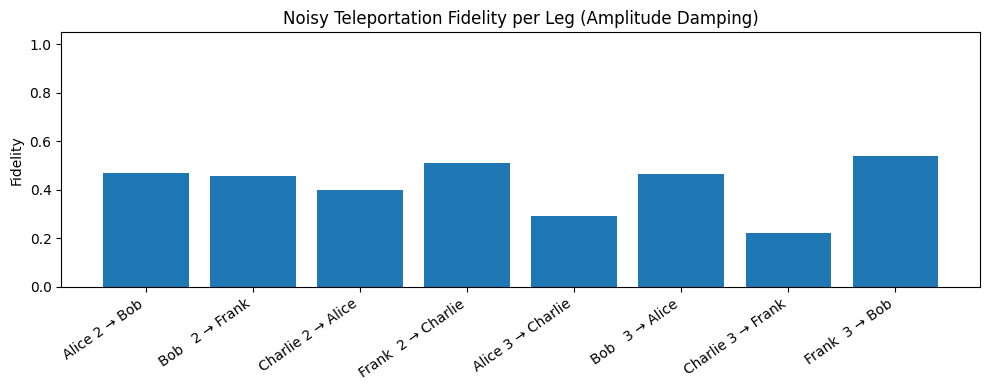

In [17]:
# Teleportation noise study (assume-zeros, no measurements): all 8 legs
# Qiskit 2.x compatible
# - Ideal run (~1.0 fidelity)
# - Amplitude damping noise with randomized gammas per leg
# - Printing a table and makes a bar chart of noisy fidelities

import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, List

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

# ---------- Gate macros ----------
def create_bell_pair(c, a, b):
    c.h(a); c.cx(a, b)

def bell_measure_unitary_2q(c, m0, m1, a0, a1):
    c.cx(m0, a0); c.h(m0)
    c.cx(m1, a1); c.h(m1)

def corrections_2q_assume_zero(c, m0, m1, a0, a1, b0, b1):
    c.cx(a0, b0); c.cz(m0, b0)
    c.cx(a1, b1); c.cz(m1, b1)

def bell_measure_unitary_3q(c, m0, m1, m2, a0, a1, a2):
    c.cx(m0, a0); c.h(m0)
    c.cx(m1, a1); c.h(m1)
    c.cx(m2, a2); c.h(m2)

def corrections_3q_assume_zero(c, m0, m1, m2, a0, a1, a2, b0, b1, b2):
    c.cx(a0, b0); c.cz(m0, b0)
    c.cx(a1, b1); c.cz(m1, b1)
    c.cx(a2, b2); c.cz(m2, b2)

# ---------- Payload preps (match our earlier choices) ----------
def prep_A1(c, q0, q1):  # (|00> + i|11>)/√2
    c.h(q0); c.cx(q0, q1); c.s(q0)

def prep_B1(c, q0, q1):  # (|00> - |11>)/√2
    c.h(q0); c.cx(q0, q1); c.z(q0)

def prep_C1(c, q0, q1):  # (|01> + |10>)/√2
    c.h(q0); c.cx(q0, q1); c.x(q1)

def prep_F1(c, q0, q1):  # (|00> - i|11>)/√2
    c.h(q0); c.cx(q0, q1); c.sdg(q1)

def prep_A2(c, q0, q1, q2):  # GHZ+ with S on q0
    c.h(q0); c.cx(q0, q1); c.cx(q0, q2); c.s(q0)

def prep_B2(c, q0, q1, q2):  # GHZ-
    c.h(q0); c.cx(q0, q1); c.cx(q0, q2); c.z(q0)

def prep_C2(c, q0, q1, q2):  # (|001> + |110>)/√2
    c.h(q0); c.cx(q0, q1); c.cx(q0, q2); c.x(q2)

def prep_F2(c, q0, q1, q2):  # GHZ+ with S† on q1
    c.h(q0); c.cx(q0, q1); c.cx(q0, q2); c.sdg(q1)

# ---------- Per-leg circuits ----------
def build_2q_leg(prep_fn: Callable[[QuantumCircuit, int, int], None]) -> Tuple[QuantumCircuit, list, list]:
    # Qubits: 0,1 message; 2,3 sender ancilla; 4,5 receiver
    qc = QuantumCircuit(6)
    prep_fn(qc, 0, 1)
    create_bell_pair(qc, 2, 4)
    create_bell_pair(qc, 3, 5)
    bell_measure_unitary_2q(qc, 0, 1, 2, 3)
    corrections_2q_assume_zero(qc, 0, 1, 2, 3, 4, 5)
    return qc, [0,1], [4,5]

def build_3q_leg(prep_fn: Callable[[QuantumCircuit, int, int, int], None]) -> Tuple[QuantumCircuit, list, list]:
    # Qubits: 0,1,2 message; 3,4,5 sender ancilla; 6,7,8 receiver
    qc = QuantumCircuit(9)
    prep_fn(qc, 0, 1, 2)
    create_bell_pair(qc, 3, 6)
    create_bell_pair(qc, 4, 7)
    create_bell_pair(qc, 5, 8)
    bell_measure_unitary_3q(qc, 0, 1, 2, 3, 4, 5)
    corrections_3q_assume_zero(qc, 0, 1, 2, 3, 4, 5, 6, 7, 8)
    return qc, [0,1,2], [6,7,8]

# ---------- Noise (amplitude damping) ----------
def build_amp_damp_noise(gamma_1q: float, gamma_2q: float = None) -> NoiseModel:
    if gamma_2q is None:
        gamma_2q = gamma_1q
    nm = NoiseModel()
    amp1 = amplitude_damping_error(gamma_1q)
    nm.add_all_qubit_quantum_error(amp1, ['h','x','z','s','sdg','id'])
    amp2 = amplitude_damping_error(gamma_2q).tensor(amplitude_damping_error(gamma_2q))
    nm.add_all_qubit_quantum_error(amp2, ['cx','cz'])
    return nm

# ---------- Run one leg (ideal + noisy) ----------
def run_leg(prep_kind: str, leg_type: str, prep_fn, gamma_range=(0.02, 0.20), seed=None):
    if seed is not None:
        random.seed(seed)

    if leg_type == '2q':
        qc, _, recv = build_2q_leg(prep_fn)
        # Ideal
        sv_final = Statevector.from_instruction(qc)
        rho_recv_ideal = partial_trace(sv_final, [i for i in range(6) if i not in recv])

        # Build the original message state (2 qubits)
        qc_in = QuantumCircuit(2); prep_fn(qc_in, 0, 1)
        rho_in = partial_trace(Statevector.from_instruction(qc_in), [])
        fid_ideal = state_fidelity(rho_in, rho_recv_ideal)

        # Noisy
        gamma_1q = random.uniform(*gamma_range)
        gamma_2q = random.uniform(*gamma_range)
        sim = AerSimulator(method="density_matrix", noise_model=build_amp_damp_noise(gamma_1q, gamma_2q))
        qcN = qc.copy()
        qcN.save_density_matrix()
        dm = sim.run(qcN).result().data(0)['density_matrix']
        rho_recv_noisy = partial_trace(dm, [i for i in range(6) if i not in recv])
        fid_noisy = state_fidelity(rho_in, rho_recv_noisy)
        return prep_kind, "2q", gamma_1q, gamma_2q, float(fid_ideal), float(fid_noisy)

    else:  # '3q'
        qc, _, recv = build_3q_leg(prep_fn)
        sv_final = Statevector.from_instruction(qc)
        rho_recv_ideal = partial_trace(sv_final, [i for i in range(9) if i not in recv])
        qc_in = QuantumCircuit(3); prep_fn(qc_in, 0, 1, 2)
        rho_in = partial_trace(Statevector.from_instruction(qc_in), [])
        fid_ideal = state_fidelity(rho_in, rho_recv_ideal)

        gamma_1q = random.uniform(*gamma_range)
        gamma_2q = random.uniform(*gamma_range)
        sim = AerSimulator(method="density_matrix", noise_model=build_amp_damp_noise(gamma_1q, gamma_2q))
        qcN = qc.copy()
        qcN.save_density_matrix()
        dm = sim.run(qcN).result().data(0)['density_matrix']
        rho_recv_noisy = partial_trace(dm, [i for i in range(9) if i not in recv])
        fid_noisy = state_fidelity(rho_in, rho_recv_noisy)
        return prep_kind, "3q", gamma_1q, gamma_2q, float(fid_ideal), float(fid_noisy)

# ---------- Run all 8 legs with random gammas and plot ----------
def run_all_with_noise(seed=11, gamma_range=(0.02, 0.20), make_plot=True):
    random.seed(seed)
    legs = [
        ("Alice 2 → Bob",      "2q", prep_A1),
        ("Bob   2 → Frank",    "2q", prep_B1),
        ("Charlie 2 → Alice",  "2q", prep_C1),
        ("Frank  2 → Charlie", "2q", prep_F1),
        ("Alice 3 → Charlie",  "3q", prep_A2),
        ("Bob   3 → Alice",    "3q", prep_B2),
        ("Charlie 3 → Frank",  "3q", prep_C2),
        ("Frank  3 → Bob",     "3q", prep_F2),
    ]
    rows = []
    for name, typ, fn in legs:
        name, typ, g1, g2, fid_ideal, fid_noisy = run_leg(name, typ, fn, gamma_range)
        rows.append((name, typ, g1, g2, fid_ideal, fid_noisy, fid_ideal - fid_noisy))

    # Nicely print a table
    print("\n=== Teleportation fidelities (ideal vs noisy per leg) ===")
    print(f"{'Leg':24s}  {'Type':3s}  {'γ1q':>7s}  {'γ2q':>7s}  {'Ideal':>9s}  {'Noisy':>9s}  {'Drop':>9s}")
    for name, typ, g1, g2, fi, fn in [(r[0],r[1],r[2],r[3],r[4],r[5]) for r in rows]:
        print(f"{name:24s}  {typ:3s}  {g1:7.3f}  {g2:7.3f}  {fi:9.6f}  {fn:9.6f}  {fi-fn:9.6f}")

    # Bar chart of noisy fidelities
    if make_plot:
        labels = [r[0] for r in rows]
        noisy_vals = [r[5] for r in rows]
        plt.figure(figsize=(10, 4))
        plt.title("Noisy Teleportation Fidelity per Leg (Amplitude Damping)")
        plt.xticks(rotation=35, ha="right")
        plt.ylabel("Fidelity")
        plt.ylim(0, 1.05)
        plt.bar(range(len(noisy_vals)), noisy_vals)
        plt.xticks(range(len(noisy_vals)), labels)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":

    run_all_with_noise(seed=11, gamma_range=(0.02, 0.20), make_plot=True)
